In [2]:
%matplotlib inline
import nest_asyncio
nest_asyncio.apply()

import multiprocessing
multiprocessing.set_start_method("fork")

import pickle
import os
import math
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import statsmodels
import stan
import arviz as az
import cmdstanpy
from cmdstanpy import cmdstan_path, CmdStanModel

In [4]:
df = pd.read_pickle("v37_synthetic_data.pkl")

In [6]:
df.groupby(['country_number'])['week'].count()

country_number
0    684
1    659
2    471
3    347
4    283
Name: week, dtype: int64

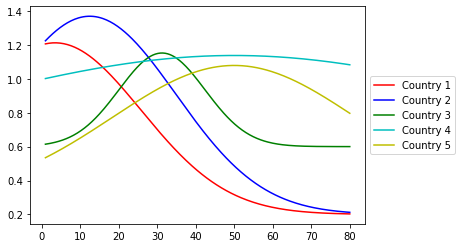

In [8]:
x_range = np.linspace(1, 80,250)

intensity1 = np.exp(-0.001*x_range**2+0.007*x_range)+.2
intensity2 = np.exp(-0.001*x_range**2+0.025*x_range)+.2
intensity3 = np.exp(-0.004*x_range**2+0.25*x_range-4.5)+.6
intensity4 = np.exp(-.0001*x_range**2+0.01*x_range-0.7)+.5
intensity5 = np.exp(-.0005*x_range**2+0.05*x_range-1.5)+.3

plt.plot(x_range, intensity1, '-r', label="Country 1")
plt.plot(x_range, intensity2, '-b', label="Country 2")
plt.plot(x_range, intensity3, '-g', label="Country 3")
plt.plot(x_range, intensity4, '-c', label="Country 4")
plt.plot(x_range, intensity5, '-y', label="Country 5")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [9]:
# Number of countries
totalN = len(df)
J = len(df.country_number.unique())
S = len(df.site_number.unique())
country = np.reshape((np.array([df.country_number])),(totalN,))+1
site = (np.reshape((np.array([df.site_number])),(totalN,)))
N = list(df.groupby(['country_number']).count().max(axis=1))
maxN = max(df.groupby(['country_number']).count().max(axis=1))
country_of_site = np.array(df.groupby(['country_number','site_number']).size().reset_index()['country_number'])+1

In [10]:
n_tilde = 150
x_tilde = np.zeros((J,n_tilde))
for i in range(J):
    x_tilde[i] = np.linspace(1., df.groupby(['country_number'])['week'].max()[i]+5, n_tilde)

In [11]:
intensity = np.zeros((J,n_tilde))
for i in range(J):
    if i == 0:
        temp_intensity = np.exp(-0.001*x_tilde[i]**2+0.007*x_tilde[i])+.2
    elif i == 1 :
        temp_intensity = np.exp(-0.001*x_tilde[i]**2+0.025*x_tilde[i])+.2
    elif i == 2 :
        temp_intensity = np.exp(-0.004*x_tilde[i]**2+0.25*x_tilde[i]-4.5)+.6
    elif i == 3 : 
        temp_intensity = np.exp(-.0001*x_tilde[i]**2+0.01*x_tilde[i]-0.7)+.5
    elif i == 4 :
        temp_intensity = np.exp(-.0005*x_tilde[i]**2+0.05*x_tilde[i]-1.5)+.3
    intensity[i] = temp_intensity

In [12]:
df[df['country_number']==0]
dfs_to_join_x = []
dfs_to_join_y = []
dfs_to_join_s = []

for j in range(J):
    temp_df = df[df['country_number']==j]
    temp_df_x = pd.DataFrame(temp_df['week'])
    temp_df_y = pd.DataFrame(temp_df['number_recruited'])
    temp_df_s = pd.DataFrame(temp_df['site_number'])

    temp_df_x = temp_df_x.reset_index(drop=True)
    temp_df_y = temp_df_y.reset_index(drop=True)
    temp_df_s = temp_df_s.reset_index(drop=True)

    dfs_to_join_x.append(temp_df_x)
    dfs_to_join_y.append(temp_df_y)
    dfs_to_join_s.append(temp_df_s)

df_to_join_x = pd.concat(dfs_to_join_x, axis=1)
df_to_join_y = pd.concat(dfs_to_join_y, axis=1)
df_to_join_s = pd.concat(dfs_to_join_s, axis=1)


df_to_join_x = df_to_join_x.fillna(0)
df_to_join_y = df_to_join_y.fillna(0)
df_to_join_s = df_to_join_s.fillna(0)

y = np.array(df_to_join_y.T).astype(int)
x = np.array(df_to_join_x.T)
site = np.array(df_to_join_s.T).astype(int)

In [13]:
synth_data = {'J': J, 'maxN': maxN, 'N': N, 'y': y, 'x': x, 'S':S, 'site':site, 'n_tilde':n_tilde, 'country_of_site':country_of_site}

# 1. HPG

In [15]:
with open('syn2_hpg.pickle', 'rb') as f:
    hpg_list = pickle.load(f)
s_hpg_model, s_hpg_fit = hpg_list

In [16]:
hpg_arviz = az.from_cmdstanpy(
    posterior= s_hpg_fit,
    observed_data={"y": y},
    log_likelihood="log_lik"
)

### Diagnostics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1d496a6d0>,
      dtype=object)

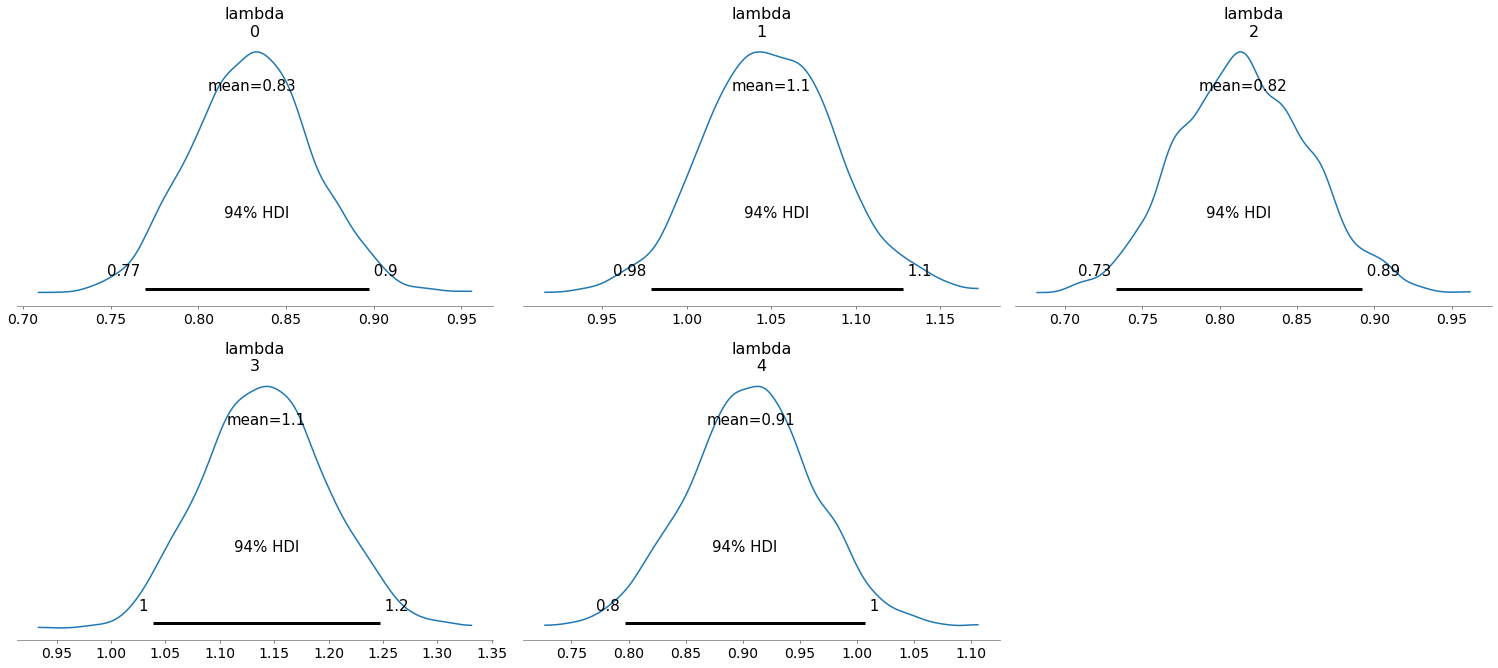

In [52]:
az.plot_posterior(hpg_arviz, var_names=['lambda'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1d4ef9910>,
      dtype=object)

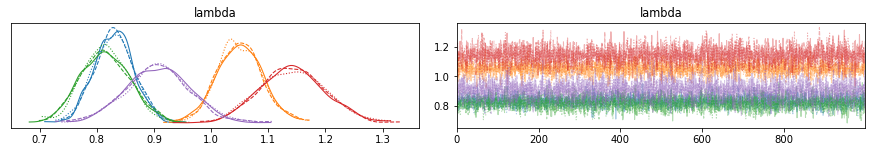

In [53]:
az.plot_trace(hpg_arviz, var_names=['lambda'])

In [54]:
az.ess(hpg_arviz, var_names=['lambda'])

<xarray.Dataset>
Dimensions:       (lambda_dim_0: 5)
Coordinates:
  * lambda_dim_0  (lambda_dim_0) int64 0 1 2 3 4
Data variables:
    lambda        (lambda_dim_0) float64 3.974e+03 4.158e+03 ... 3.873e+03

In [55]:
az.rhat(hpg_arviz, var_names=['lambda'])

<xarray.Dataset>
Dimensions:       (lambda_dim_0: 5)
Coordinates:
  * lambda_dim_0  (lambda_dim_0) int64 0 1 2 3 4
Data variables:
    lambda        (lambda_dim_0) float64 1.001 1.001 1.002 1.001 1.002

# 2. HHPG

In [17]:
with open('syn2_hhpg.pickle', 'rb') as f:
    hhpg_list = pickle.load(f)
s_hhpg_model, s_hhpg_fit = hhpg_list

In [18]:
hhpg_arviz = az.from_cmdstanpy(
    posterior= s_hhpg_fit,
    observed_data={"y": y},
    log_likelihood="log_lik"
)

### Diagnostics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff199ce0760>,
      dtype=object)

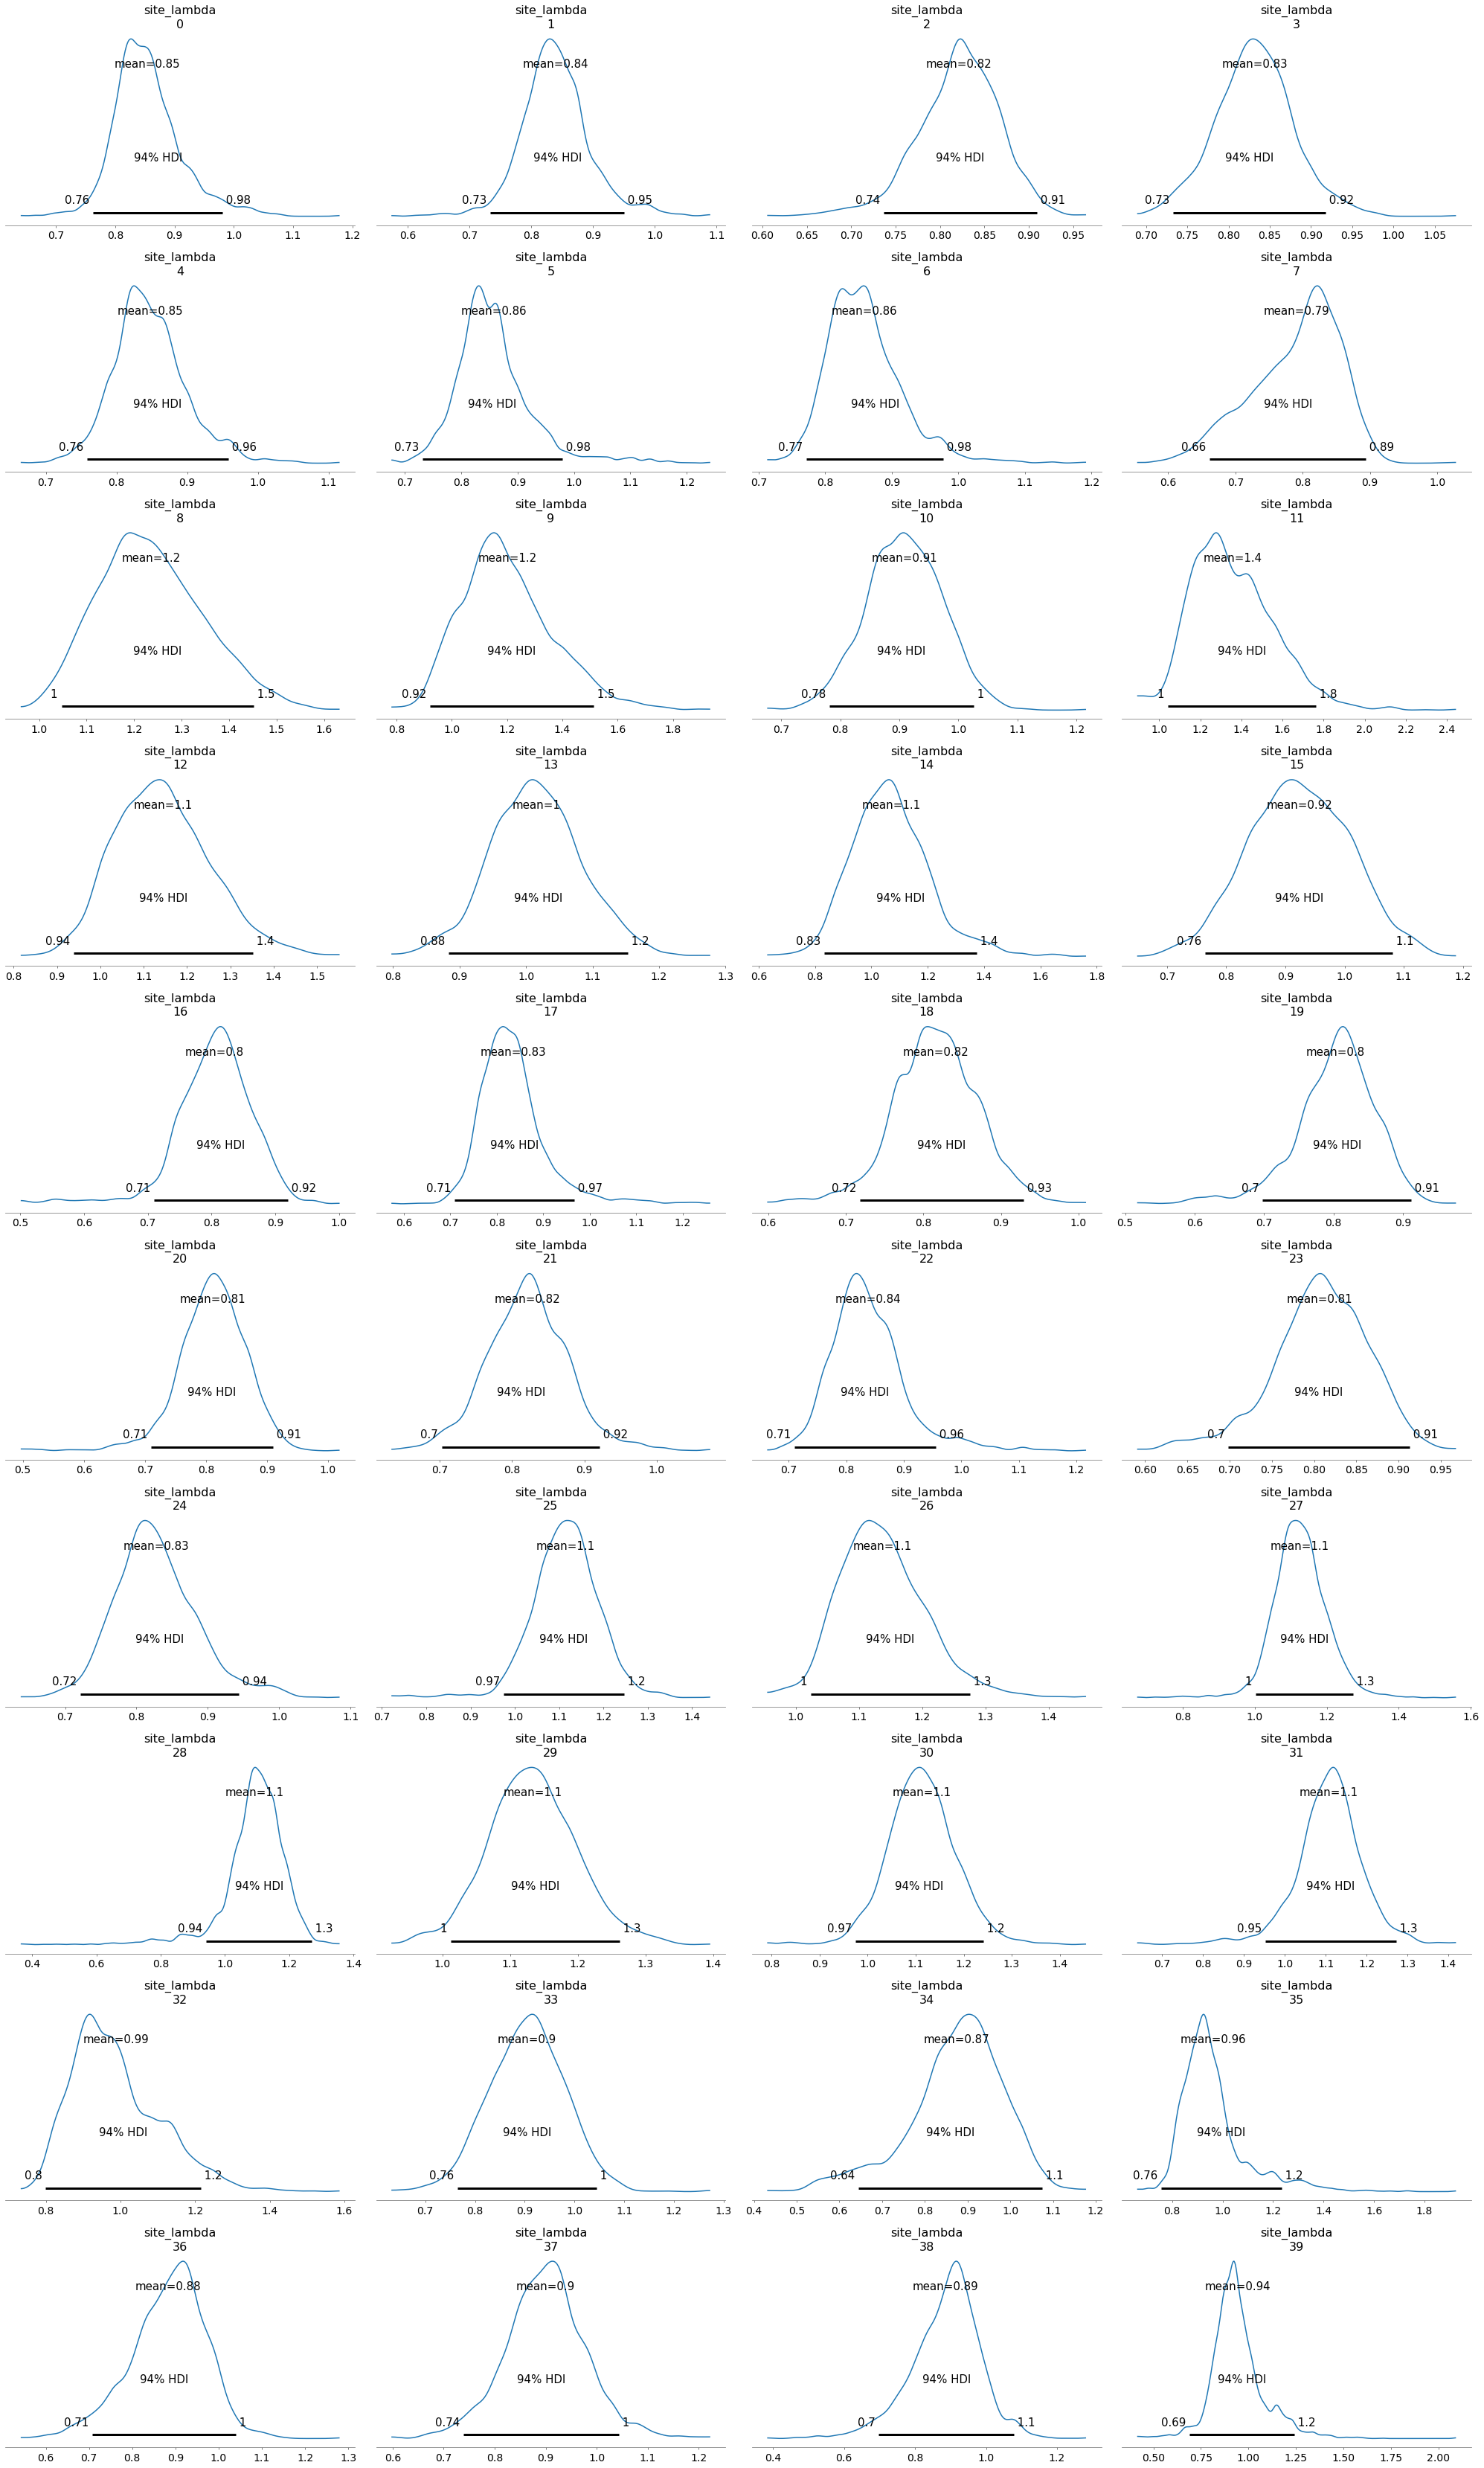

In [110]:
az.plot_posterior(hhpg_arviz, var_names=['site_lambda'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1ca48b0a0>,
      dtype=object)

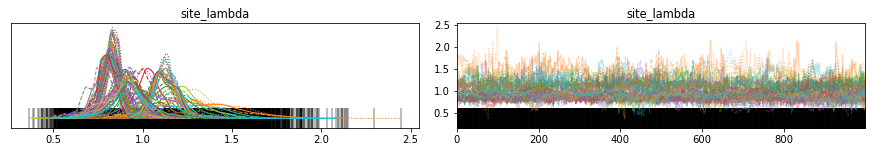

In [106]:
az.plot_trace(hhpg_arviz, var_names=['site_lambda'])

In [109]:
az.ess(hhpg_arviz, var_names=['site_lambda'])

<xarray.Dataset>
Dimensions:            (site_lambda_dim_0: 40)
Coordinates:
  * site_lambda_dim_0  (site_lambda_dim_0) int64 0 1 2 3 4 5 ... 35 36 37 38 39
Data variables:
    site_lambda        (site_lambda_dim_0) float64 27.15 71.55 ... 63.64 12.55

In [108]:
az.rhat(hhpg_arviz, var_names=['site_lambda'])

<xarray.Dataset>
Dimensions:            (site_lambda_dim_0: 40)
Coordinates:
  * site_lambda_dim_0  (site_lambda_dim_0) int64 0 1 2 3 4 5 ... 35 36 37 38 39
Data variables:
    site_lambda        (site_lambda_dim_0) float64 1.089 1.026 ... 1.033 1.189

# 3. CLM

In [19]:
with open('syn2_clm.pickle', 'rb') as f:
    clm_list = pickle.load(f)
s_clm_model, s_clm_fit = clm_list

In [20]:
clm_arviz = az.from_cmdstanpy(
    posterior= s_clm_fit,
    observed_data={"y": y},
    log_likelihood="log_lik"
)

### Diagnostics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1b9a3d910>,
      dtype=object)

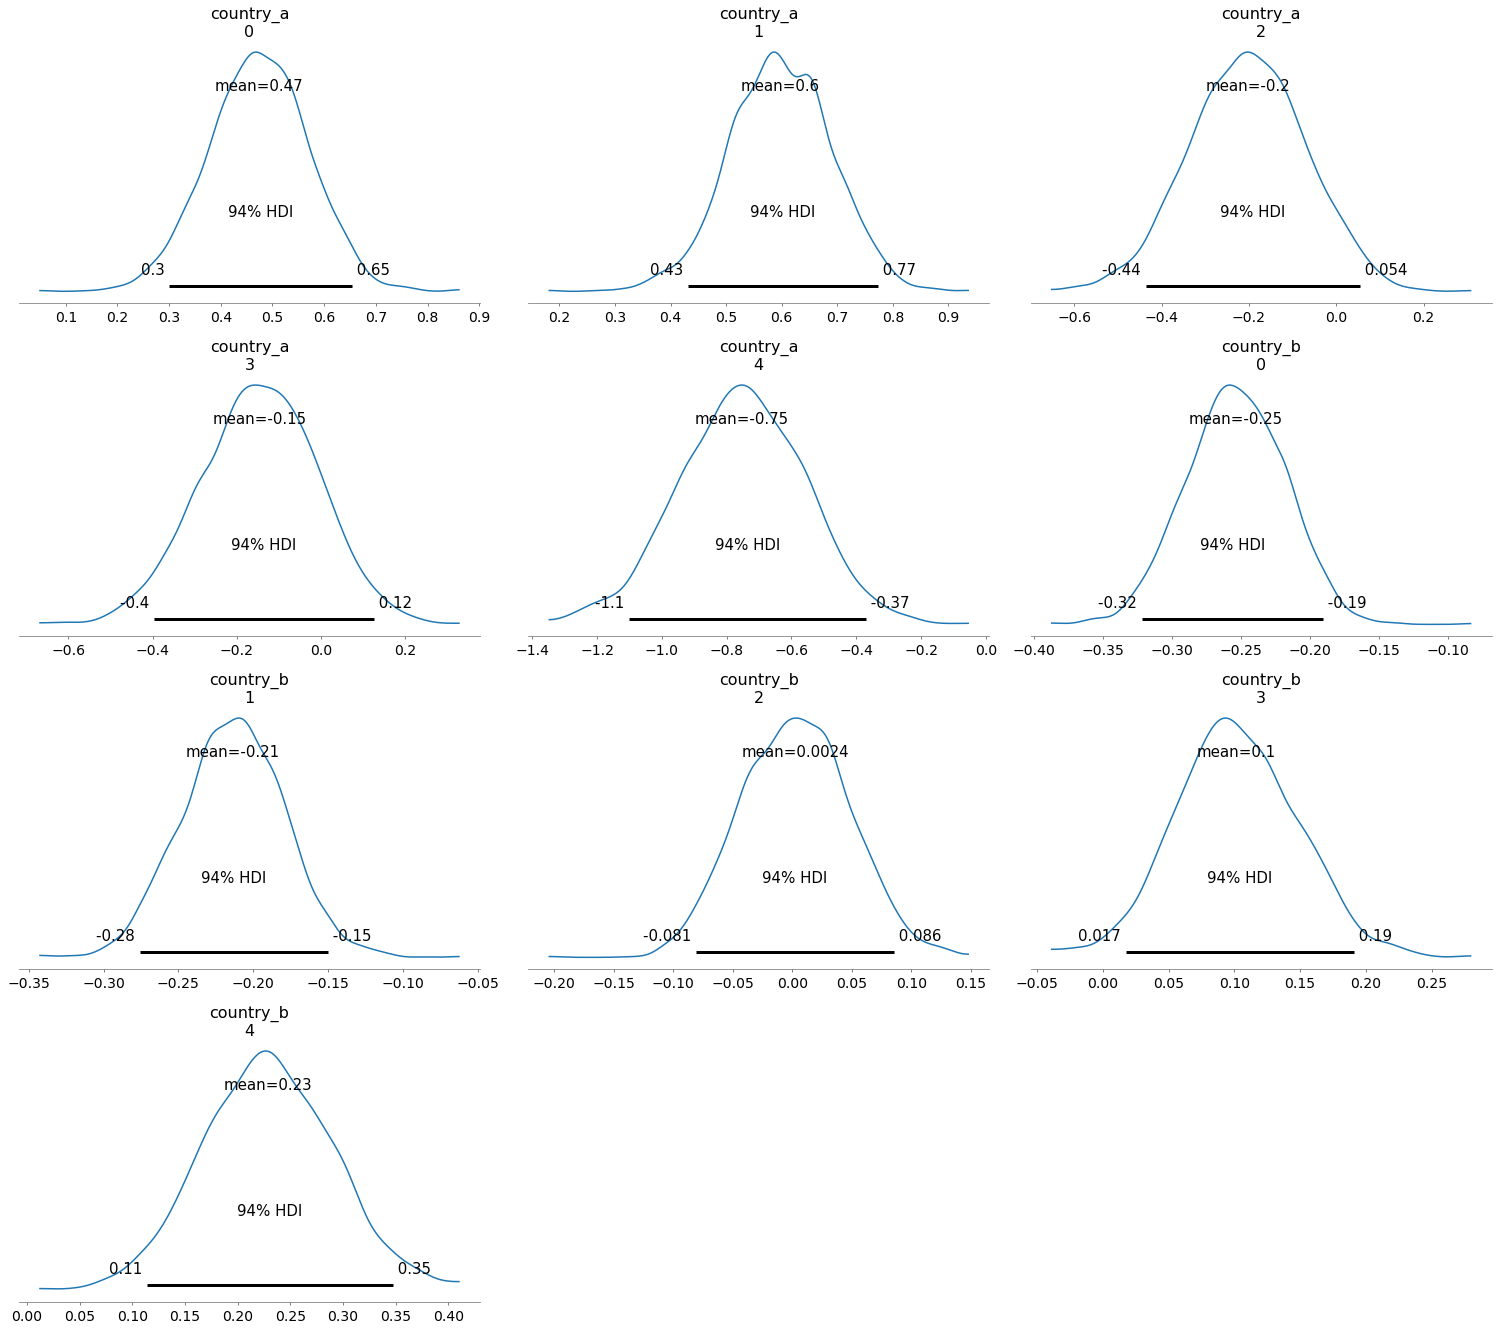

In [118]:
az.plot_posterior(clm_arviz, var_names=['country_a','country_b'])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1899e42e0>,
      dtype=object)

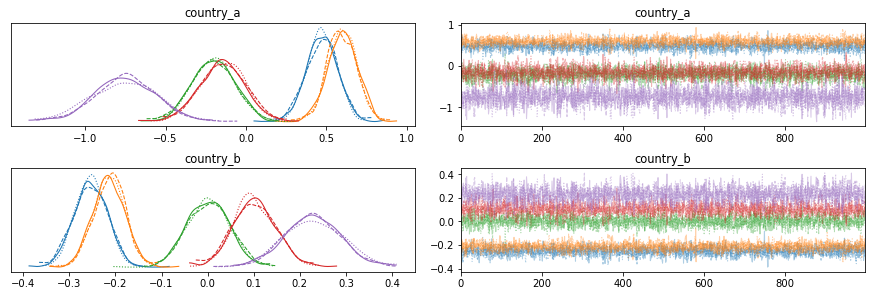

In [119]:
az.plot_trace(clm_arviz, var_names=['country_a','country_b'])


In [121]:
az.ess(clm_arviz, var_names=['country_a','country_b'])


<xarray.Dataset>
Dimensions:          (country_a_dim_0: 5, country_b_dim_0: 5)
Coordinates:
  * country_a_dim_0  (country_a_dim_0) int64 0 1 2 3 4
  * country_b_dim_0  (country_b_dim_0) int64 0 1 2 3 4
Data variables:
    country_a        (country_a_dim_0) float64 2.875e+03 2.818e+03 ... 2.359e+03
    country_b        (country_b_dim_0) float64 2.903e+03 2.835e+03 ... 2.453e+03

In [120]:
az.rhat(clm_arviz, var_names=['country_a','country_b'])

<xarray.Dataset>
Dimensions:          (country_a_dim_0: 5, country_b_dim_0: 5)
Coordinates:
  * country_a_dim_0  (country_a_dim_0) int64 0 1 2 3 4
  * country_b_dim_0  (country_b_dim_0) int64 0 1 2 3 4
Data variables:
    country_a        (country_a_dim_0) float64 1.004 1.002 1.0 1.001 1.003
    country_b        (country_b_dim_0) float64 1.002 1.0 1.001 1.001 1.003

# 4. HCLM

In [21]:
with open('syn2_hclm.pickle', 'rb') as f:
    hclm_list = pickle.load(f)
s_hclm_model, s_hclm_fit = hclm_list

In [22]:
hclm_arviz = az.from_cmdstanpy(
    posterior= s_hclm_fit,
    observed_data={"y": y},
    log_likelihood="log_lik"
)

### Diagnostics

In [ ]:
az.plot_posterior(hclm_arviz, var_names=['site_a','site_b'])

In [ ]:
az.plot_trace(hclm_arviz, var_names=['site_a','site_b'])

In [ ]:
az.ess(hclm_arviz, var_names=['site_a','site_b'])

In [124]:
az.rhat(hclm_arviz, var_names=['site_a','site_b'])

<xarray.Dataset>
Dimensions:       (site_a_dim_0: 40, site_b_dim_0: 40)
Coordinates:
  * site_a_dim_0  (site_a_dim_0) int64 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39
  * site_b_dim_0  (site_b_dim_0) int64 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39
Data variables:
    site_a        (site_a_dim_0) float64 1.001 1.0 1.0 ... 0.9999 0.9996 0.9996
    site_b        (site_b_dim_0) float64 0.9998 0.9996 0.9995 ... 0.9999 1.0 1.0

# 5. LGCP

In [23]:
with open('syn2_non_hier.pickle', 'rb') as f:
    lgcp_list = pickle.load(f)
s_lgcp_model, s_lgcp_fit = lgcp_list

In [24]:
lgcp_arviz = az.from_cmdstanpy(
    posterior= s_lgcp_fit,
    observed_data={"y": y},
    log_likelihood="log_lik"
)

### Diagnostics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1b94fda00>,
      dtype=object)

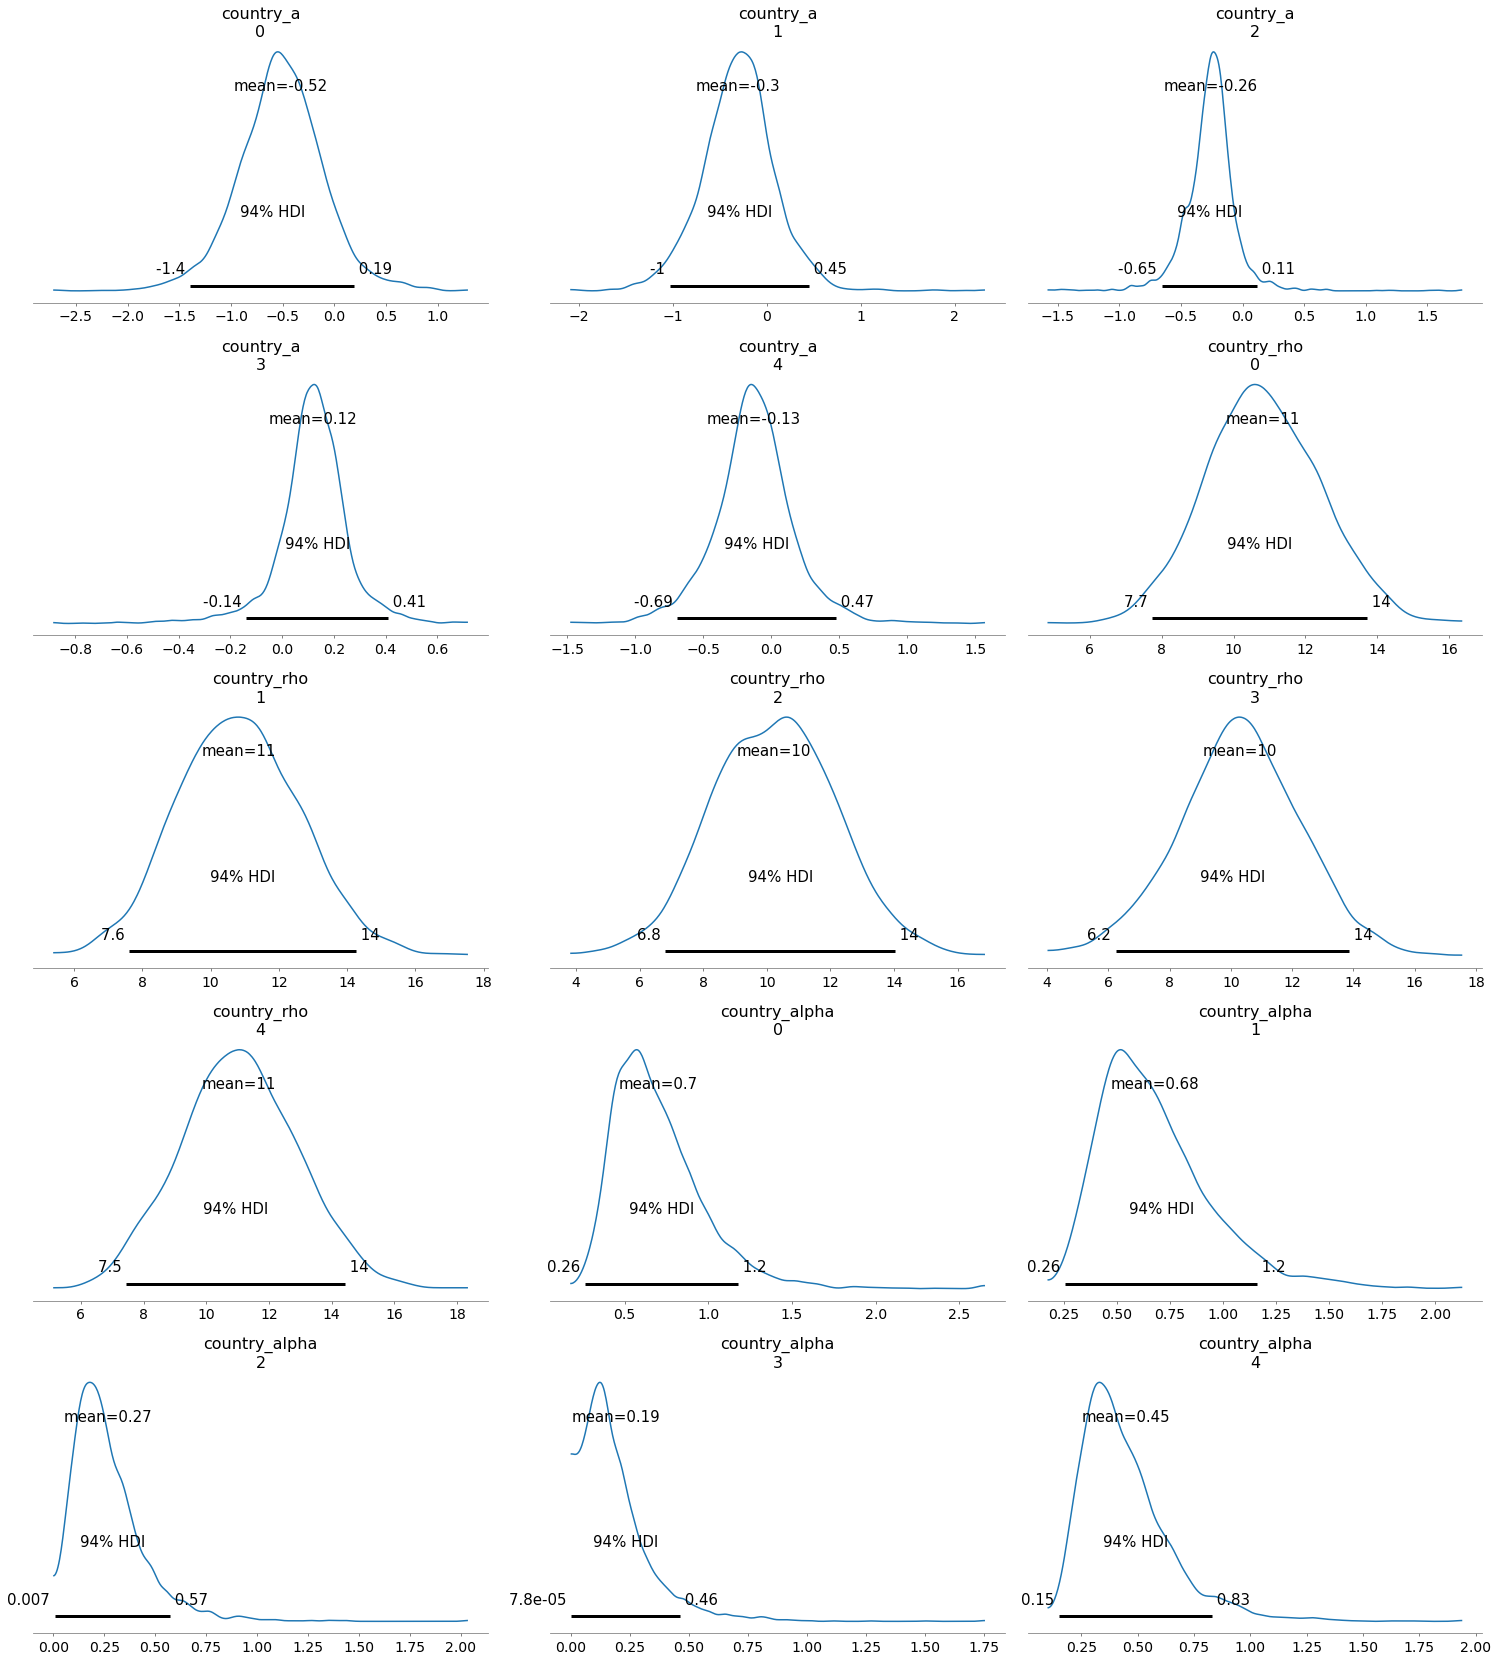

In [161]:
az.plot_posterior(lgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8181ee88e0>,
      dtype=object)

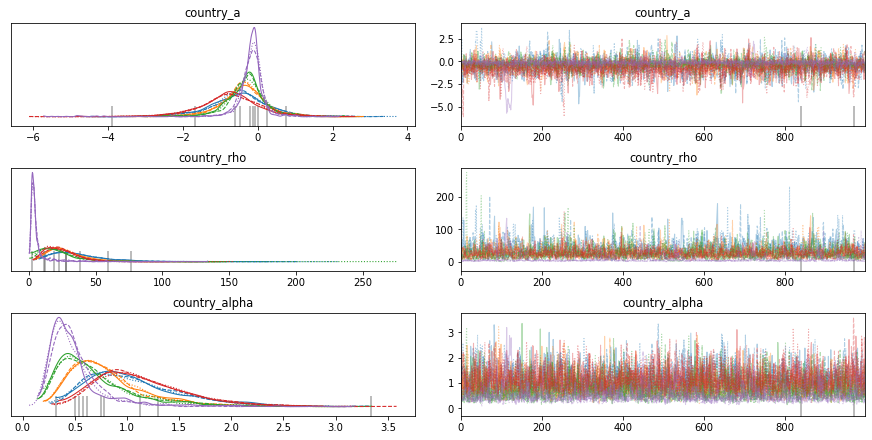

In [14]:
az.plot_trace(lgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha'])

In [15]:
az.ess(lgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha'])

<xarray.Dataset>
Dimensions:              (country_a_dim_0: 5, country_rho_dim_0: 5, country_alpha_dim_0: 5)
Coordinates:
  * country_a_dim_0      (country_a_dim_0) int64 0 1 2 3 4
  * country_rho_dim_0    (country_rho_dim_0) int64 0 1 2 3 4
  * country_alpha_dim_0  (country_alpha_dim_0) int64 0 1 2 3 4
Data variables:
    country_a            (country_a_dim_0) float64 947.8 971.6 ... 994.3
    country_rho          (country_rho_dim_0) float64 1.473e+03 ... 2.025e+03
    country_alpha        (country_alpha_dim_0) float64 1.074e+03 ... 1.259e+03

In [16]:
az.rhat(lgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha'])

<xarray.Dataset>
Dimensions:              (country_a_dim_0: 5, country_rho_dim_0: 5, country_alpha_dim_0: 5)
Coordinates:
  * country_a_dim_0      (country_a_dim_0) int64 0 1 2 3 4
  * country_rho_dim_0    (country_rho_dim_0) int64 0 1 2 3 4
  * country_alpha_dim_0  (country_alpha_dim_0) int64 0 1 2 3 4
Data variables:
    country_a            (country_a_dim_0) float64 1.006 1.002 1.005 1.002 1.002
    country_rho          (country_rho_dim_0) float64 1.001 0.9999 ... 1.005 1.0
    country_alpha        (country_alpha_dim_0) float64 1.002 1.001 ... 1.003 1.0

# 6. HLGCP

In [25]:
with open('syn2_hier.pickle', 'rb') as f:
    hlgcp_list = pickle.load(f)
s_hlgcp_model, s_hlgcp_fit = hlgcp_list

In [26]:
hlgcp_arviz = az.from_cmdstanpy(
    posterior=s_hlgcp_fit,
    observed_data={"y": y},
    log_likelihood="log_lik"
)

### Diagnostics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff70352c2b0>,
      dtype=object)

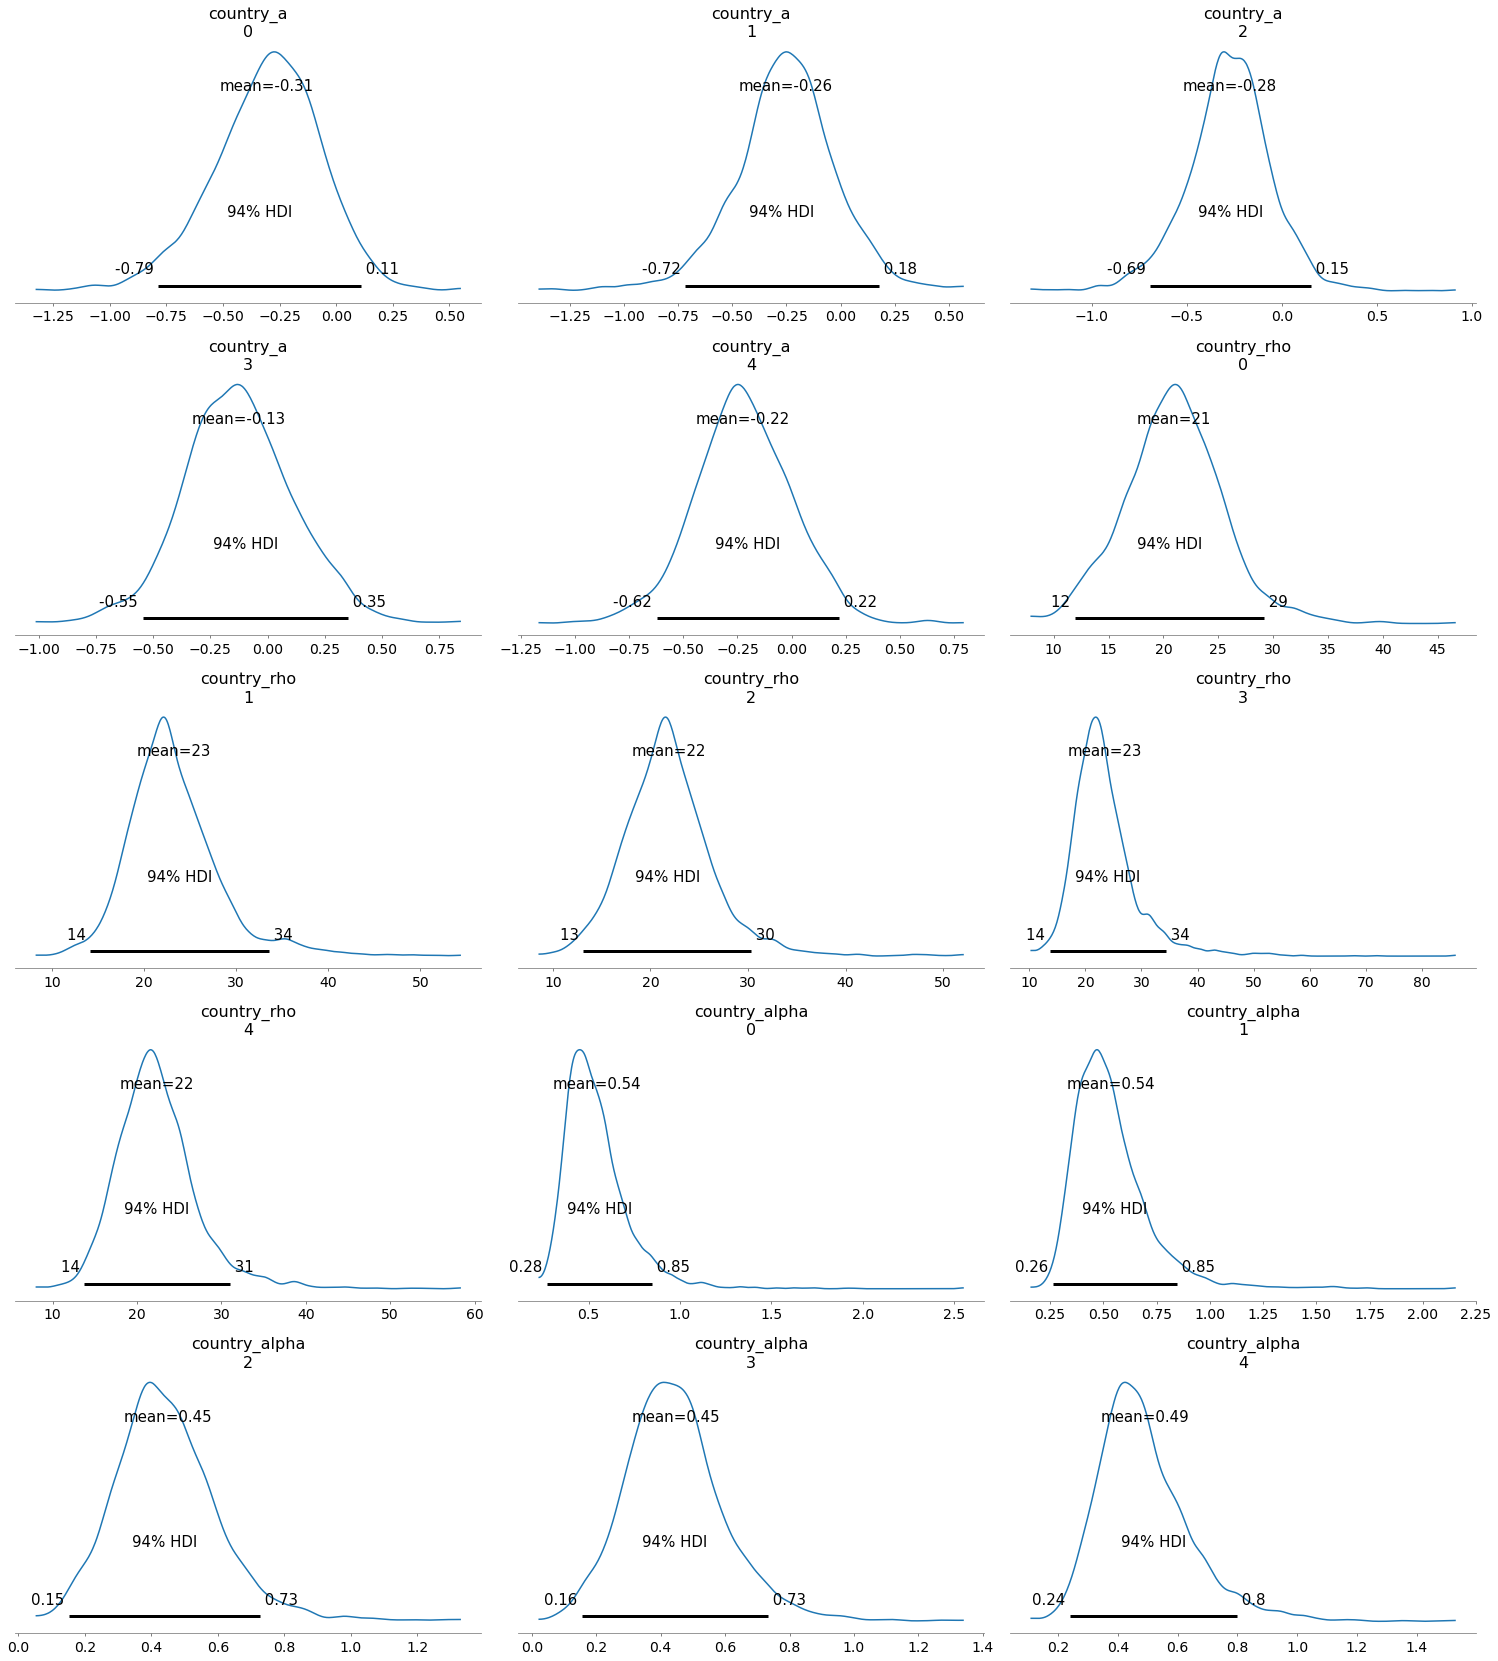

In [35]:
az.plot_posterior(hlgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff719762730>,
      dtype=object)

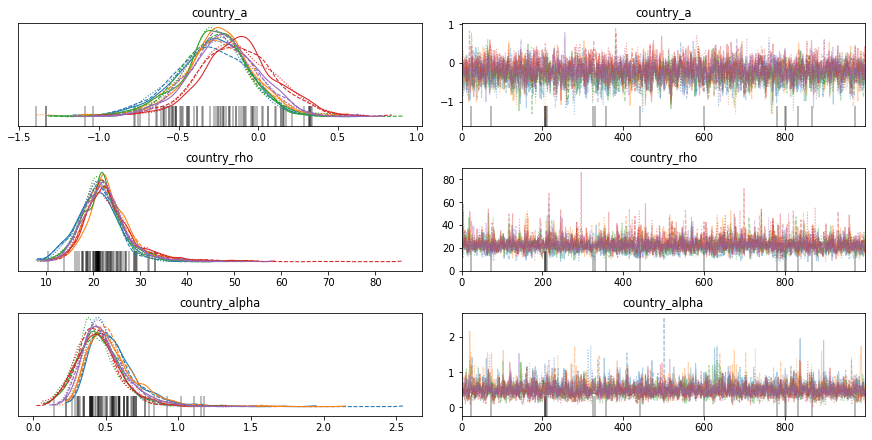

In [36]:
az.plot_trace(hlgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha'])

In [37]:
az.ess(hlgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha'])

<xarray.Dataset>
Dimensions:              (country_a_dim_0: 5, country_rho_dim_0: 5, country_alpha_dim_0: 5)
Coordinates:
  * country_rho_dim_0    (country_rho_dim_0) int64 0 1 2 3 4
  * country_alpha_dim_0  (country_alpha_dim_0) int64 0 1 2 3 4
  * country_a_dim_0      (country_a_dim_0) int64 0 1 2 3 4
Data variables:
    country_a            (country_a_dim_0) float64 1.069e+03 ... 1.193e+03
    country_rho          (country_rho_dim_0) float64 936.7 ... 1.406e+03
    country_alpha        (country_alpha_dim_0) float64 1.27e+03 ... 1.502e+03

In [38]:
az.rhat(hlgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha'])

<xarray.Dataset>
Dimensions:              (country_a_dim_0: 5, country_rho_dim_0: 5, country_alpha_dim_0: 5)
Coordinates:
  * country_rho_dim_0    (country_rho_dim_0) int64 0 1 2 3 4
  * country_alpha_dim_0  (country_alpha_dim_0) int64 0 1 2 3 4
  * country_a_dim_0      (country_a_dim_0) int64 0 1 2 3 4
Data variables:
    country_a            (country_a_dim_0) float64 1.006 1.001 1.001 1.001 1.003
    country_rho          (country_rho_dim_0) float64 1.001 1.003 ... 1.004 1.001
    country_alpha        (country_alpha_dim_0) float64 1.007 1.006 ... 1.001

# 7. HLGCPT

In [34]:
with open('syn2_hier_trend.pickle', 'rb') as f:
    hlgcpt_list = pickle.load(f)
s_hlgcpt_model, s_hlgcpt_fit = hlgcpt_list

In [35]:
hlgcpt_arviz = az.from_cmdstanpy(
    posterior=s_hlgcpt_fit,
    observed_data={"y": y},
    log_likelihood="log_lik"
)

### Diagnostics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7211fabb0>,
      dtype=object)

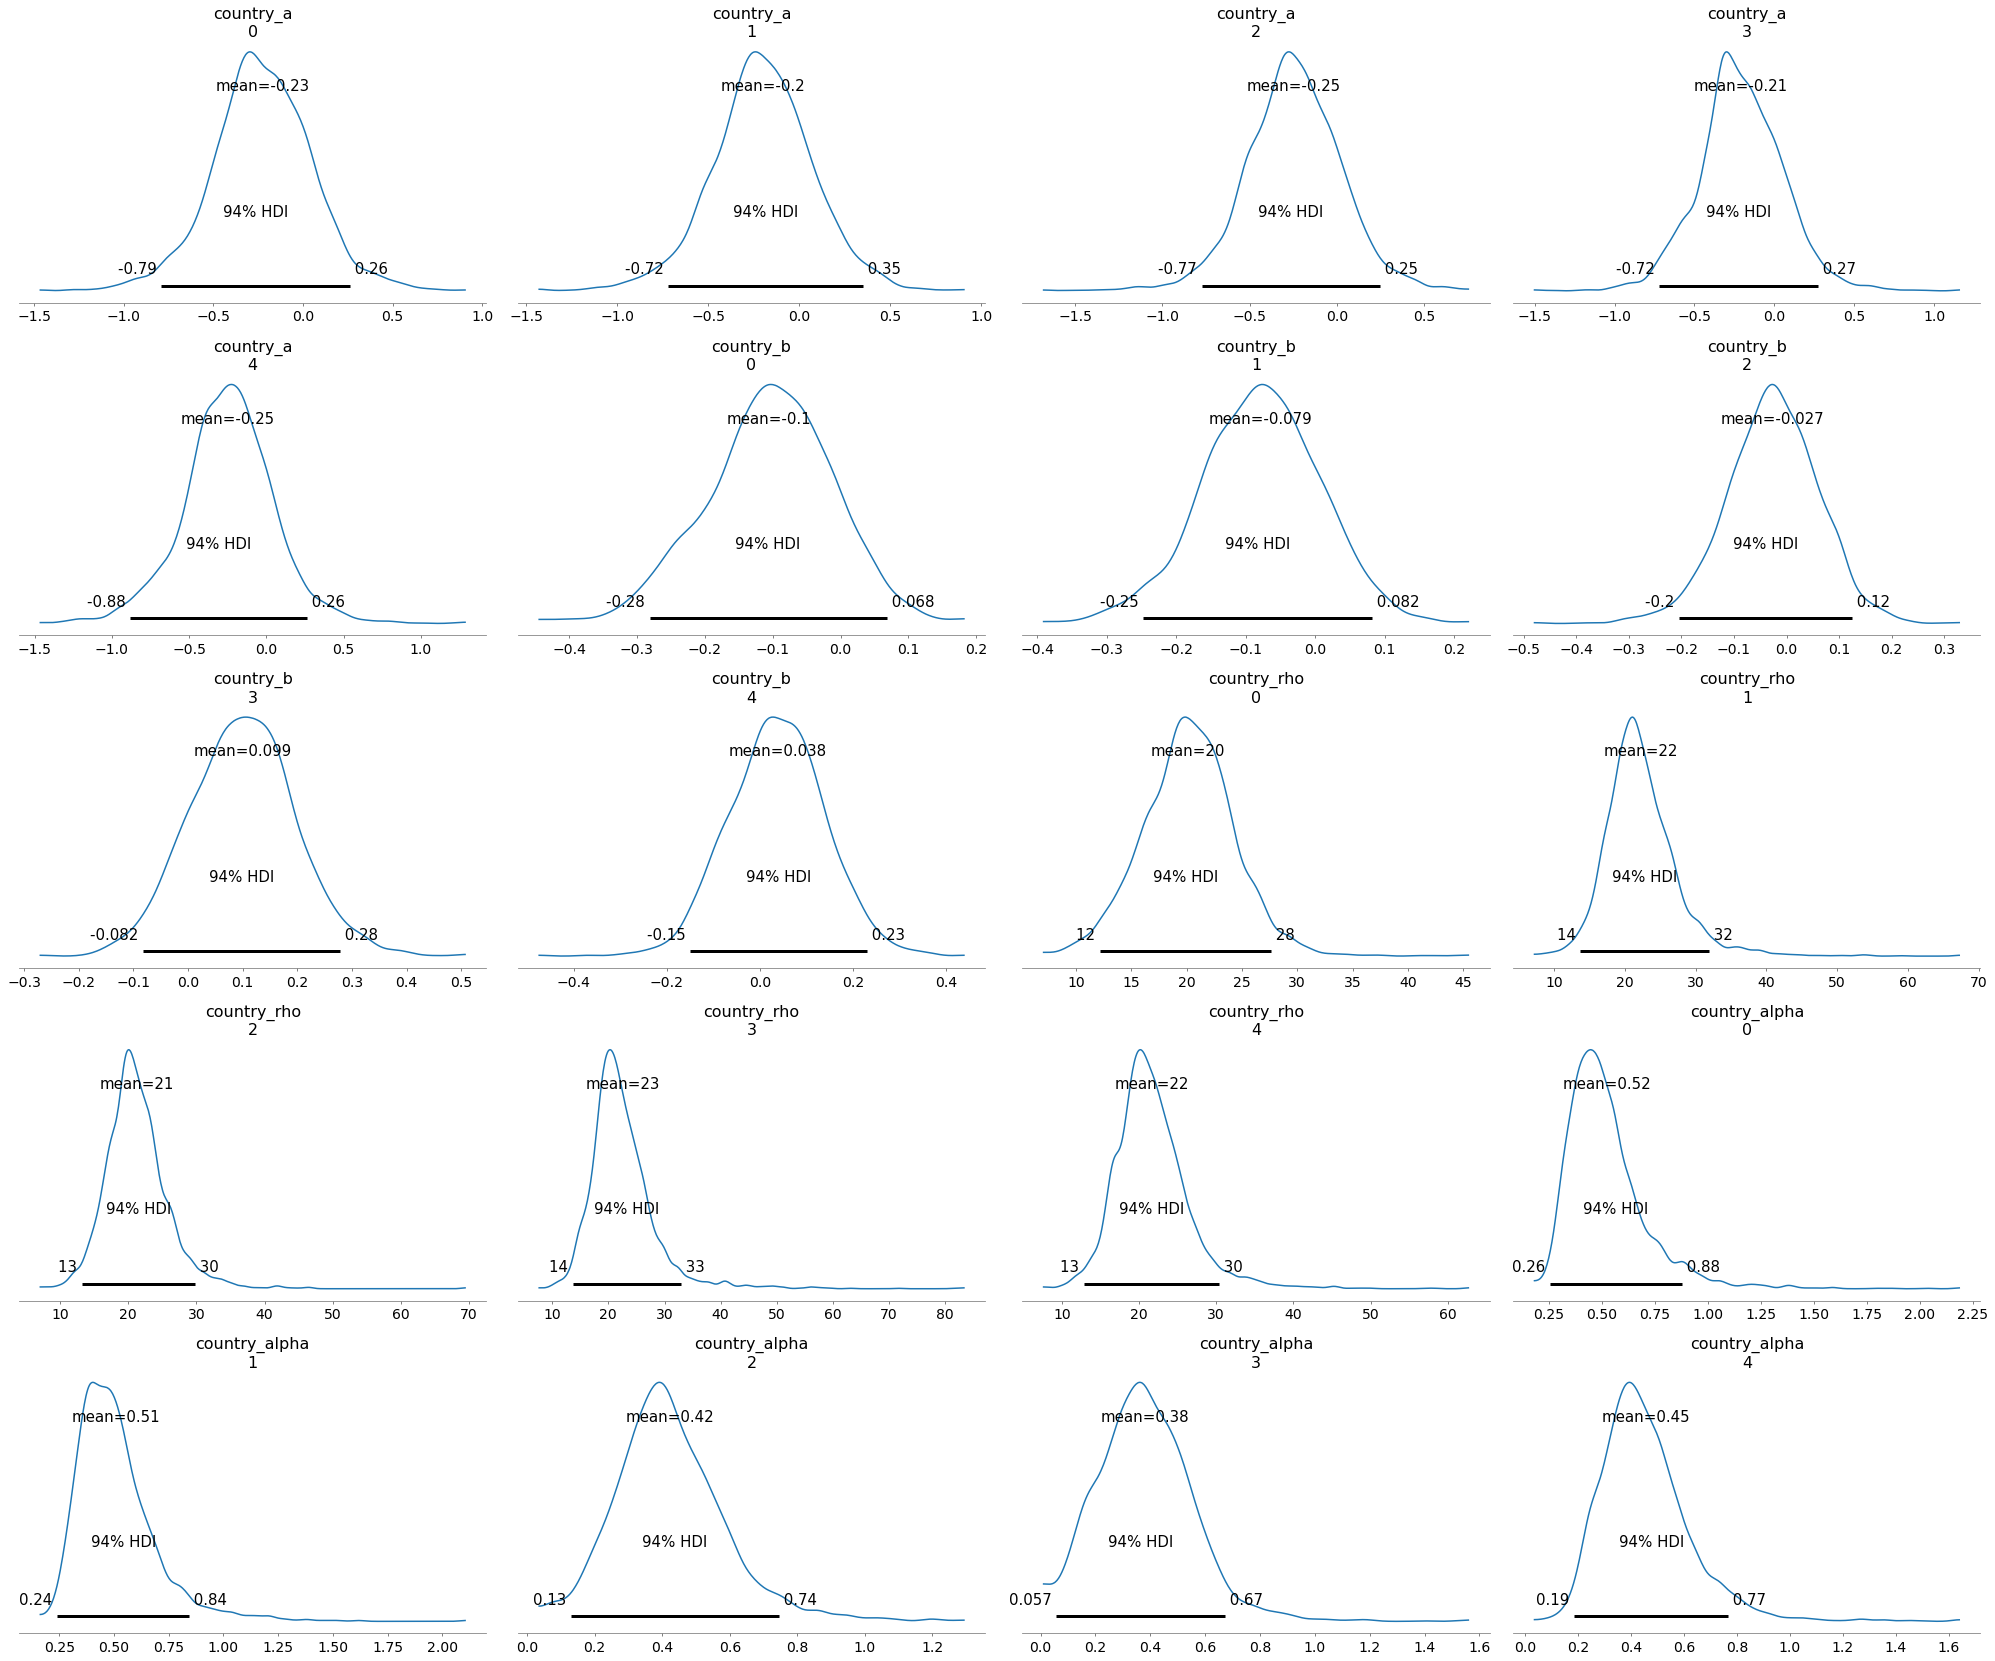

In [43]:
az.plot_posterior(hlgcpt_arviz, var_names=['country_a', 'country_b','country_rho', 'country_alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff719f89370>,
      dtype=object)

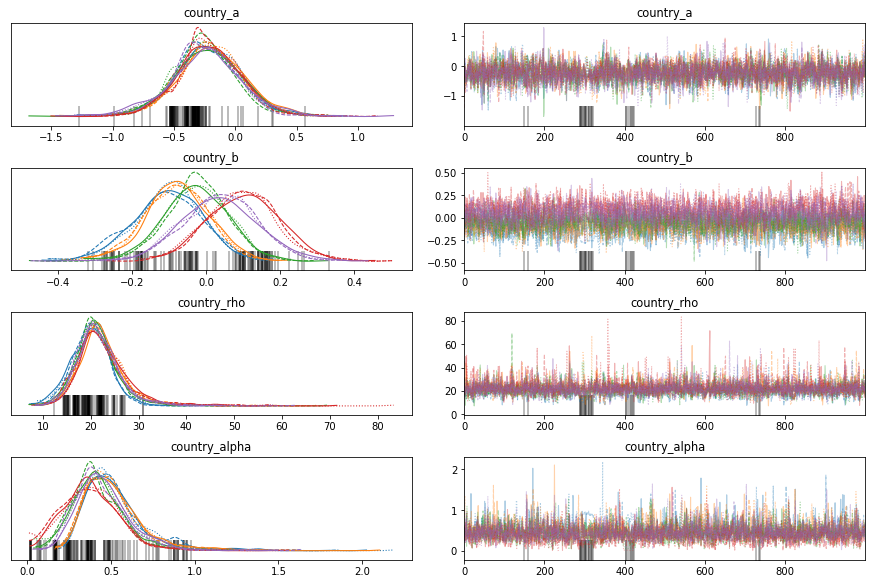

In [44]:
az.plot_trace(hlgcpt_arviz, var_names=['country_a','country_b', 'country_rho', 'country_alpha'])

In [45]:
az.ess(hlgcpt_arviz, var_names=['country_a','country_b', 'country_rho', 'country_alpha'])

<xarray.Dataset>
Dimensions:              (country_a_dim_0: 5, country_b_dim_0: 5, country_rho_dim_0: 5, country_alpha_dim_0: 5)
Coordinates:
  * country_rho_dim_0    (country_rho_dim_0) int64 0 1 2 3 4
  * country_alpha_dim_0  (country_alpha_dim_0) int64 0 1 2 3 4
  * country_a_dim_0      (country_a_dim_0) int64 0 1 2 3 4
  * country_b_dim_0      (country_b_dim_0) int64 0 1 2 3 4
Data variables:
    country_a            (country_a_dim_0) float64 1.394e+03 ... 1.494e+03
    country_b            (country_b_dim_0) float64 1.471e+03 ... 1.454e+03
    country_rho          (country_rho_dim_0) float64 1.032e+03 ... 1.293e+03
    country_alpha        (country_alpha_dim_0) float64 1.334e+03 ... 1.147e+03

In [46]:
az.rhat(hlgcpt_arviz, var_names=['country_a','country_b', 'country_rho', 'country_alpha'])

<xarray.Dataset>
Dimensions:              (country_a_dim_0: 5, country_b_dim_0: 5, country_rho_dim_0: 5, country_alpha_dim_0: 5)
Coordinates:
  * country_rho_dim_0    (country_rho_dim_0) int64 0 1 2 3 4
  * country_alpha_dim_0  (country_alpha_dim_0) int64 0 1 2 3 4
  * country_a_dim_0      (country_a_dim_0) int64 0 1 2 3 4
  * country_b_dim_0      (country_b_dim_0) int64 0 1 2 3 4
Data variables:
    country_a            (country_a_dim_0) float64 1.002 1.003 1.003 1.001 1.002
    country_b            (country_b_dim_0) float64 1.003 1.0 1.001 1.001 1.001
    country_rho          (country_rho_dim_0) float64 1.002 1.002 ... 1.002 1.004
    country_alpha        (country_alpha_dim_0) float64 1.001 1.0 ... 1.003 1.005

# 8. HSGCP

In [27]:
with open('syn2_sigmoidal.pickle', 'rb') as f:
    hsgcp_list = pickle.load(f)
s_hsgcp_model, s_hsgcp_fit = hsgcp_list

In [28]:
hsgcp_arviz = az.from_cmdstanpy(
    posterior=s_hsgcp_fit,
    observed_data={"y": y},
    log_likelihood="log_lik"
)

### Diagnostics

/Users/skim/opt/anaconda3/envs/stan/lib/python3.8/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (55) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff713212c40>,
      dtype=object)

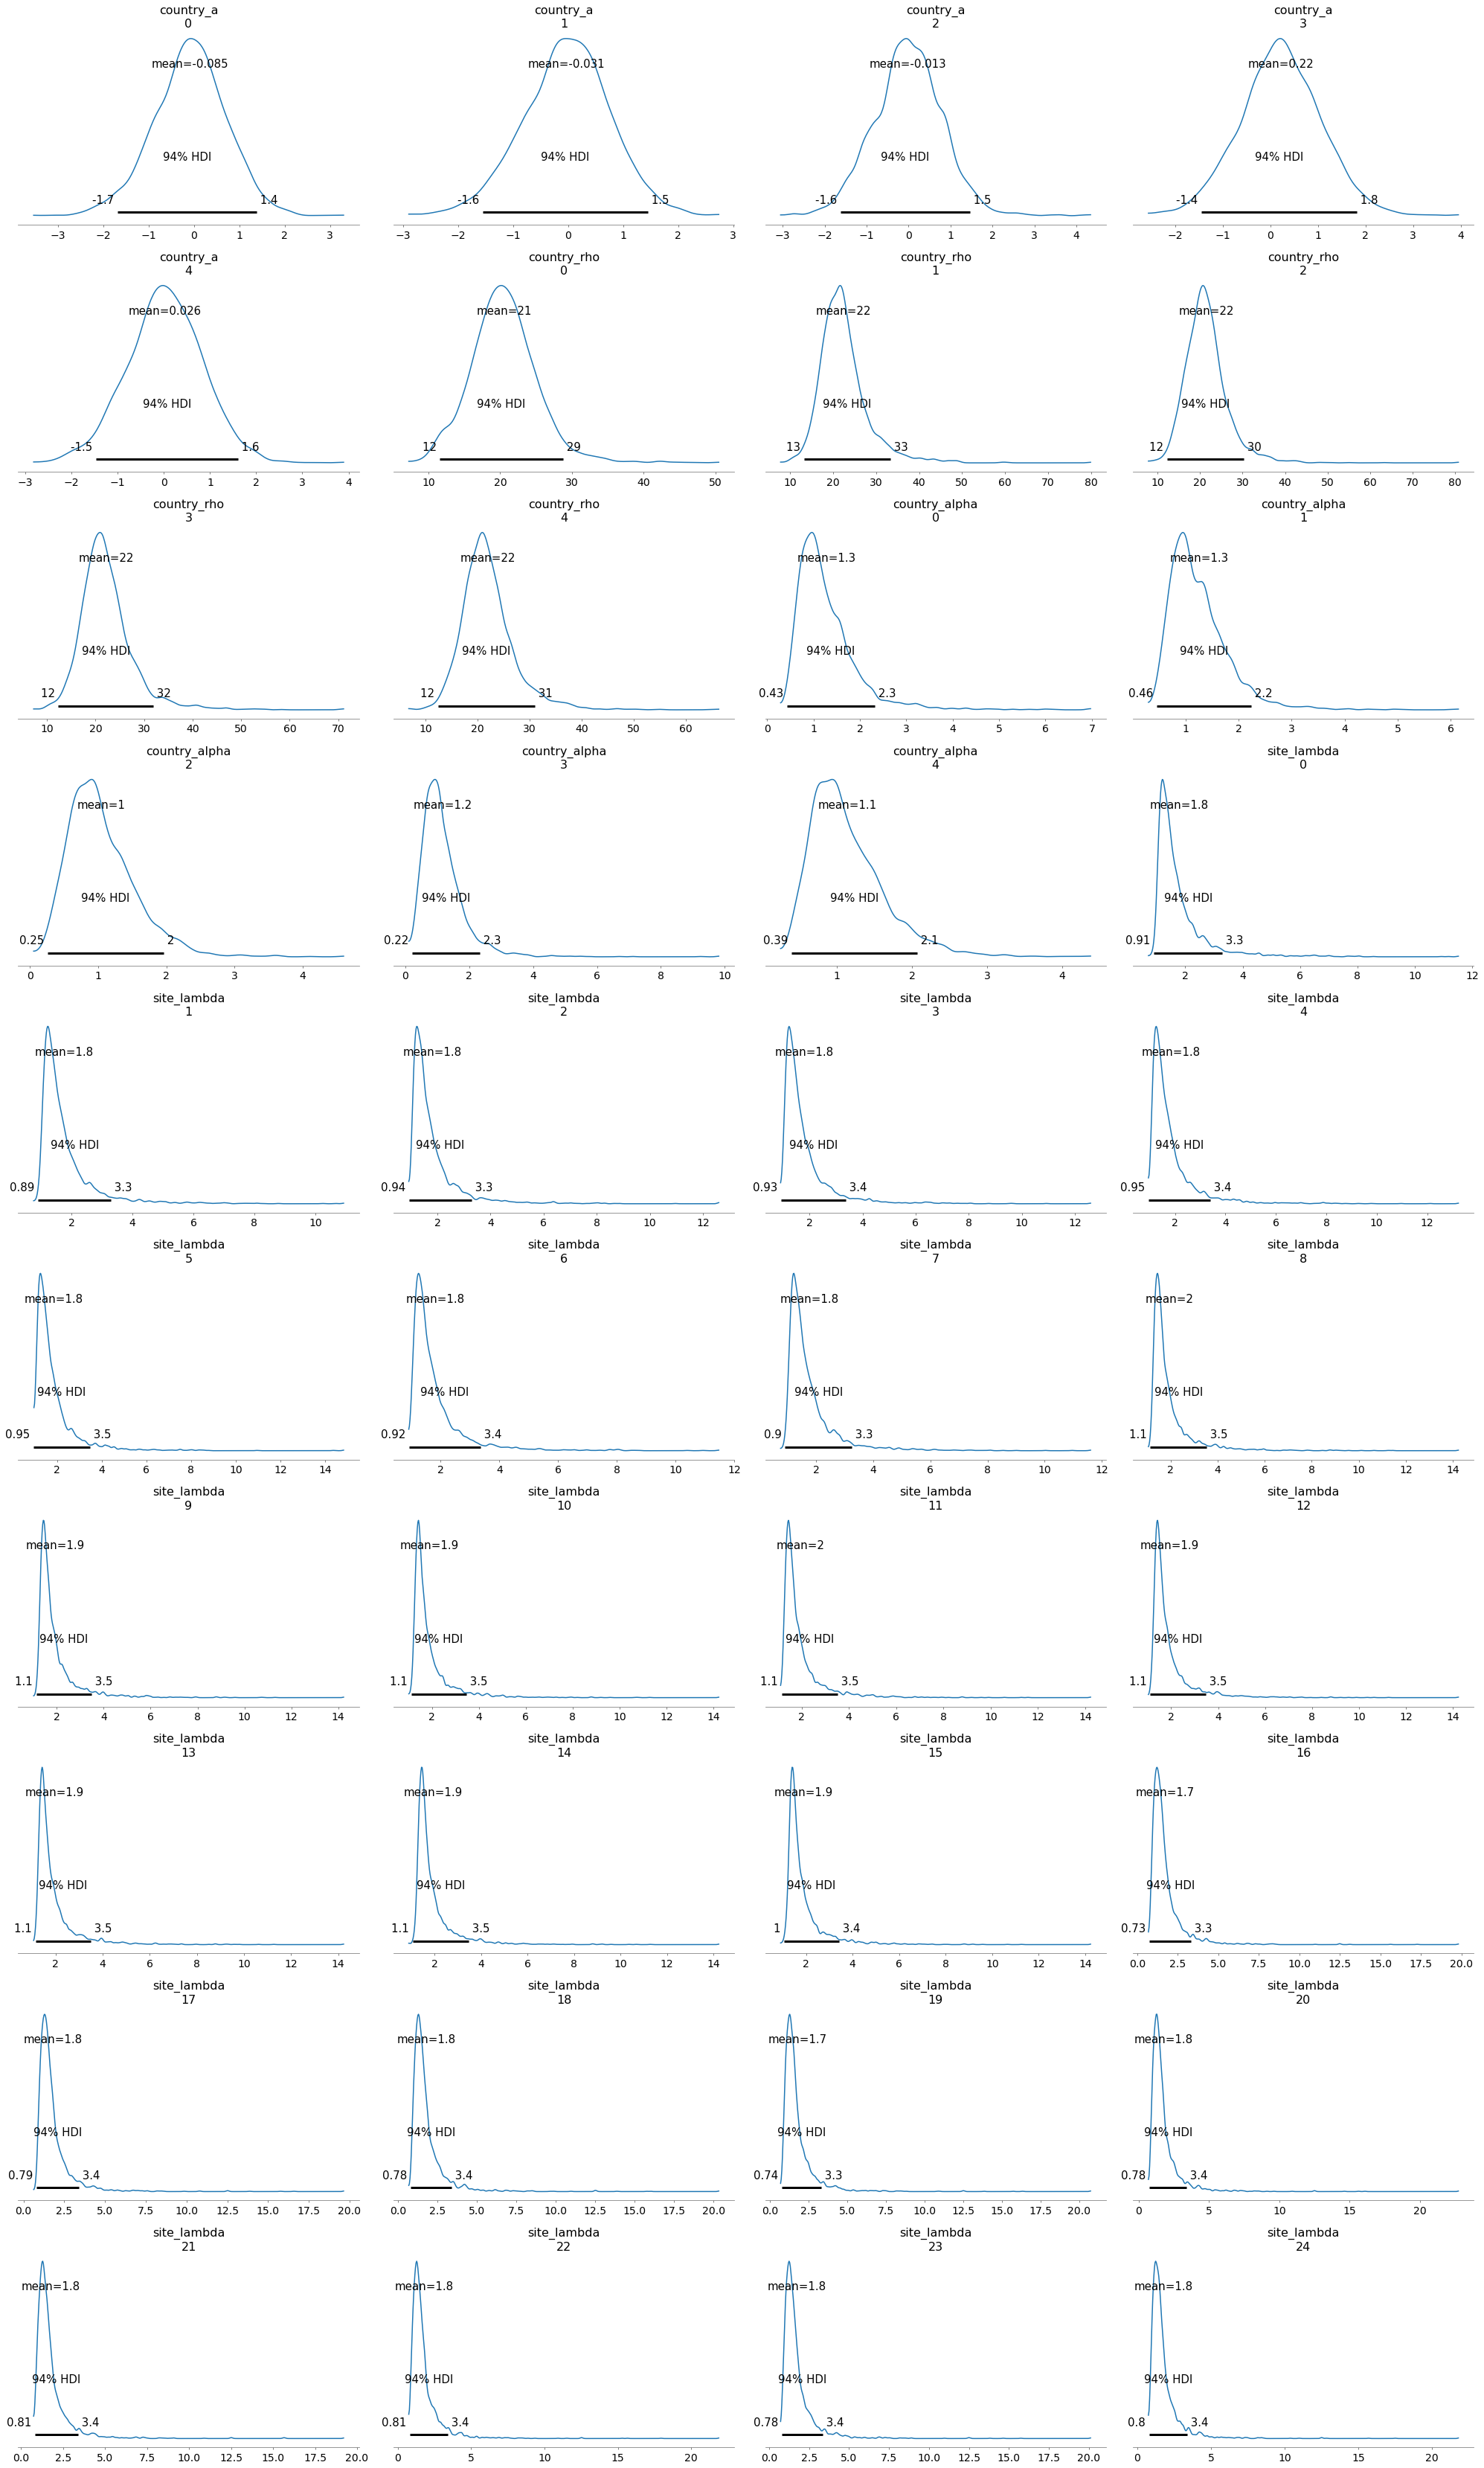

In [55]:
az.plot_posterior(hsgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha', 'site_lambda'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff720db7610>,
      dtype=object)

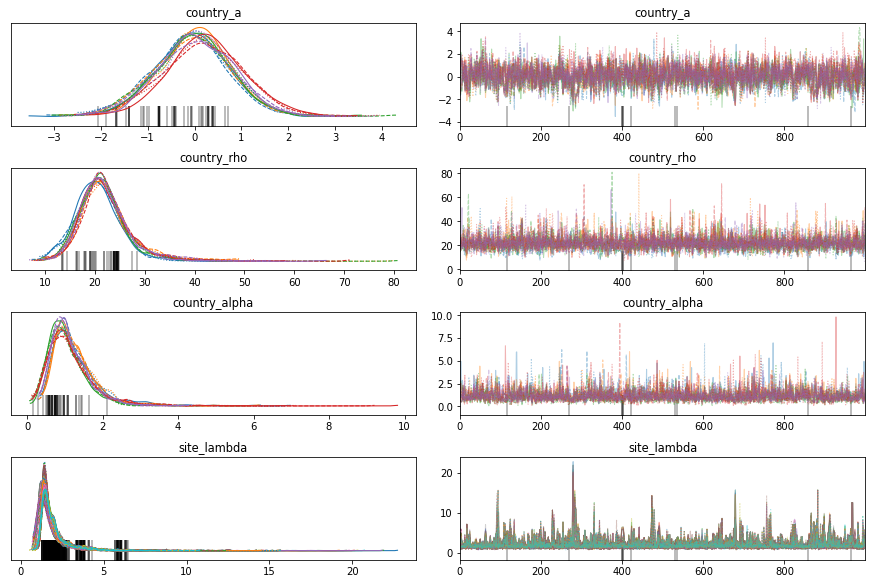

In [56]:
az.plot_trace(hsgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha', 'site_lambda'])

In [57]:
az.ess(hsgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha', 'site_lambda'])

<xarray.Dataset>
Dimensions:              (country_a_dim_0: 5, country_rho_dim_0: 5, country_alpha_dim_0: 5, site_lambda_dim_0: 40)
Coordinates:
  * country_rho_dim_0    (country_rho_dim_0) int64 0 1 2 3 4
  * country_alpha_dim_0  (country_alpha_dim_0) int64 0 1 2 3 4
  * country_a_dim_0      (country_a_dim_0) int64 0 1 2 3 4
  * site_lambda_dim_0    (site_lambda_dim_0) int64 0 1 2 3 4 ... 35 36 37 38 39
Data variables:
    country_a            (country_a_dim_0) float64 1.217e+03 ... 1.192e+03
    country_rho          (country_rho_dim_0) float64 1.08e+03 ... 2.062e+03
    country_alpha        (country_alpha_dim_0) float64 1.326e+03 ... 1.442e+03
    site_lambda          (site_lambda_dim_0) float64 1.049e+03 ... 1.269e+03

In [58]:
az.rhat(hsgcp_arviz, var_names=['country_a', 'country_rho', 'country_alpha', 'site_lambda'])

<xarray.Dataset>
Dimensions:              (country_a_dim_0: 5, country_rho_dim_0: 5, country_alpha_dim_0: 5, site_lambda_dim_0: 40)
Coordinates:
  * country_rho_dim_0    (country_rho_dim_0) int64 0 1 2 3 4
  * country_alpha_dim_0  (country_alpha_dim_0) int64 0 1 2 3 4
  * country_a_dim_0      (country_a_dim_0) int64 0 1 2 3 4
  * site_lambda_dim_0    (site_lambda_dim_0) int64 0 1 2 3 4 ... 35 36 37 38 39
Data variables:
    country_a            (country_a_dim_0) float64 1.001 1.002 1.0 1.001 1.001
    country_rho          (country_rho_dim_0) float64 1.0 1.002 1.001 1.001 1.002
    country_alpha        (country_alpha_dim_0) float64 1.002 1.0 1.001 1.0 1.0
    site_lambda          (site_lambda_dim_0) float64 1.001 1.001 ... 1.001 1.001

# 9. HSGCPT

In [29]:
with open('syn2_sigmoidal_trend.pickle', 'rb') as f:
    hsgcpt_list = pickle.load(f)
s_hsgcpt_model, s_hsgcpt_fit = hsgcpt_list

In [30]:
hsgcpt_arviz = az.from_cmdstanpy(
    posterior=s_hsgcpt_fit,
    observed_data={"y": y},
    log_likelihood="log_lik"
)

## Diagnostics

/Users/skim/opt/anaconda3/envs/stan/lib/python3.8/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (55) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff713898640>,
      dtype=object)

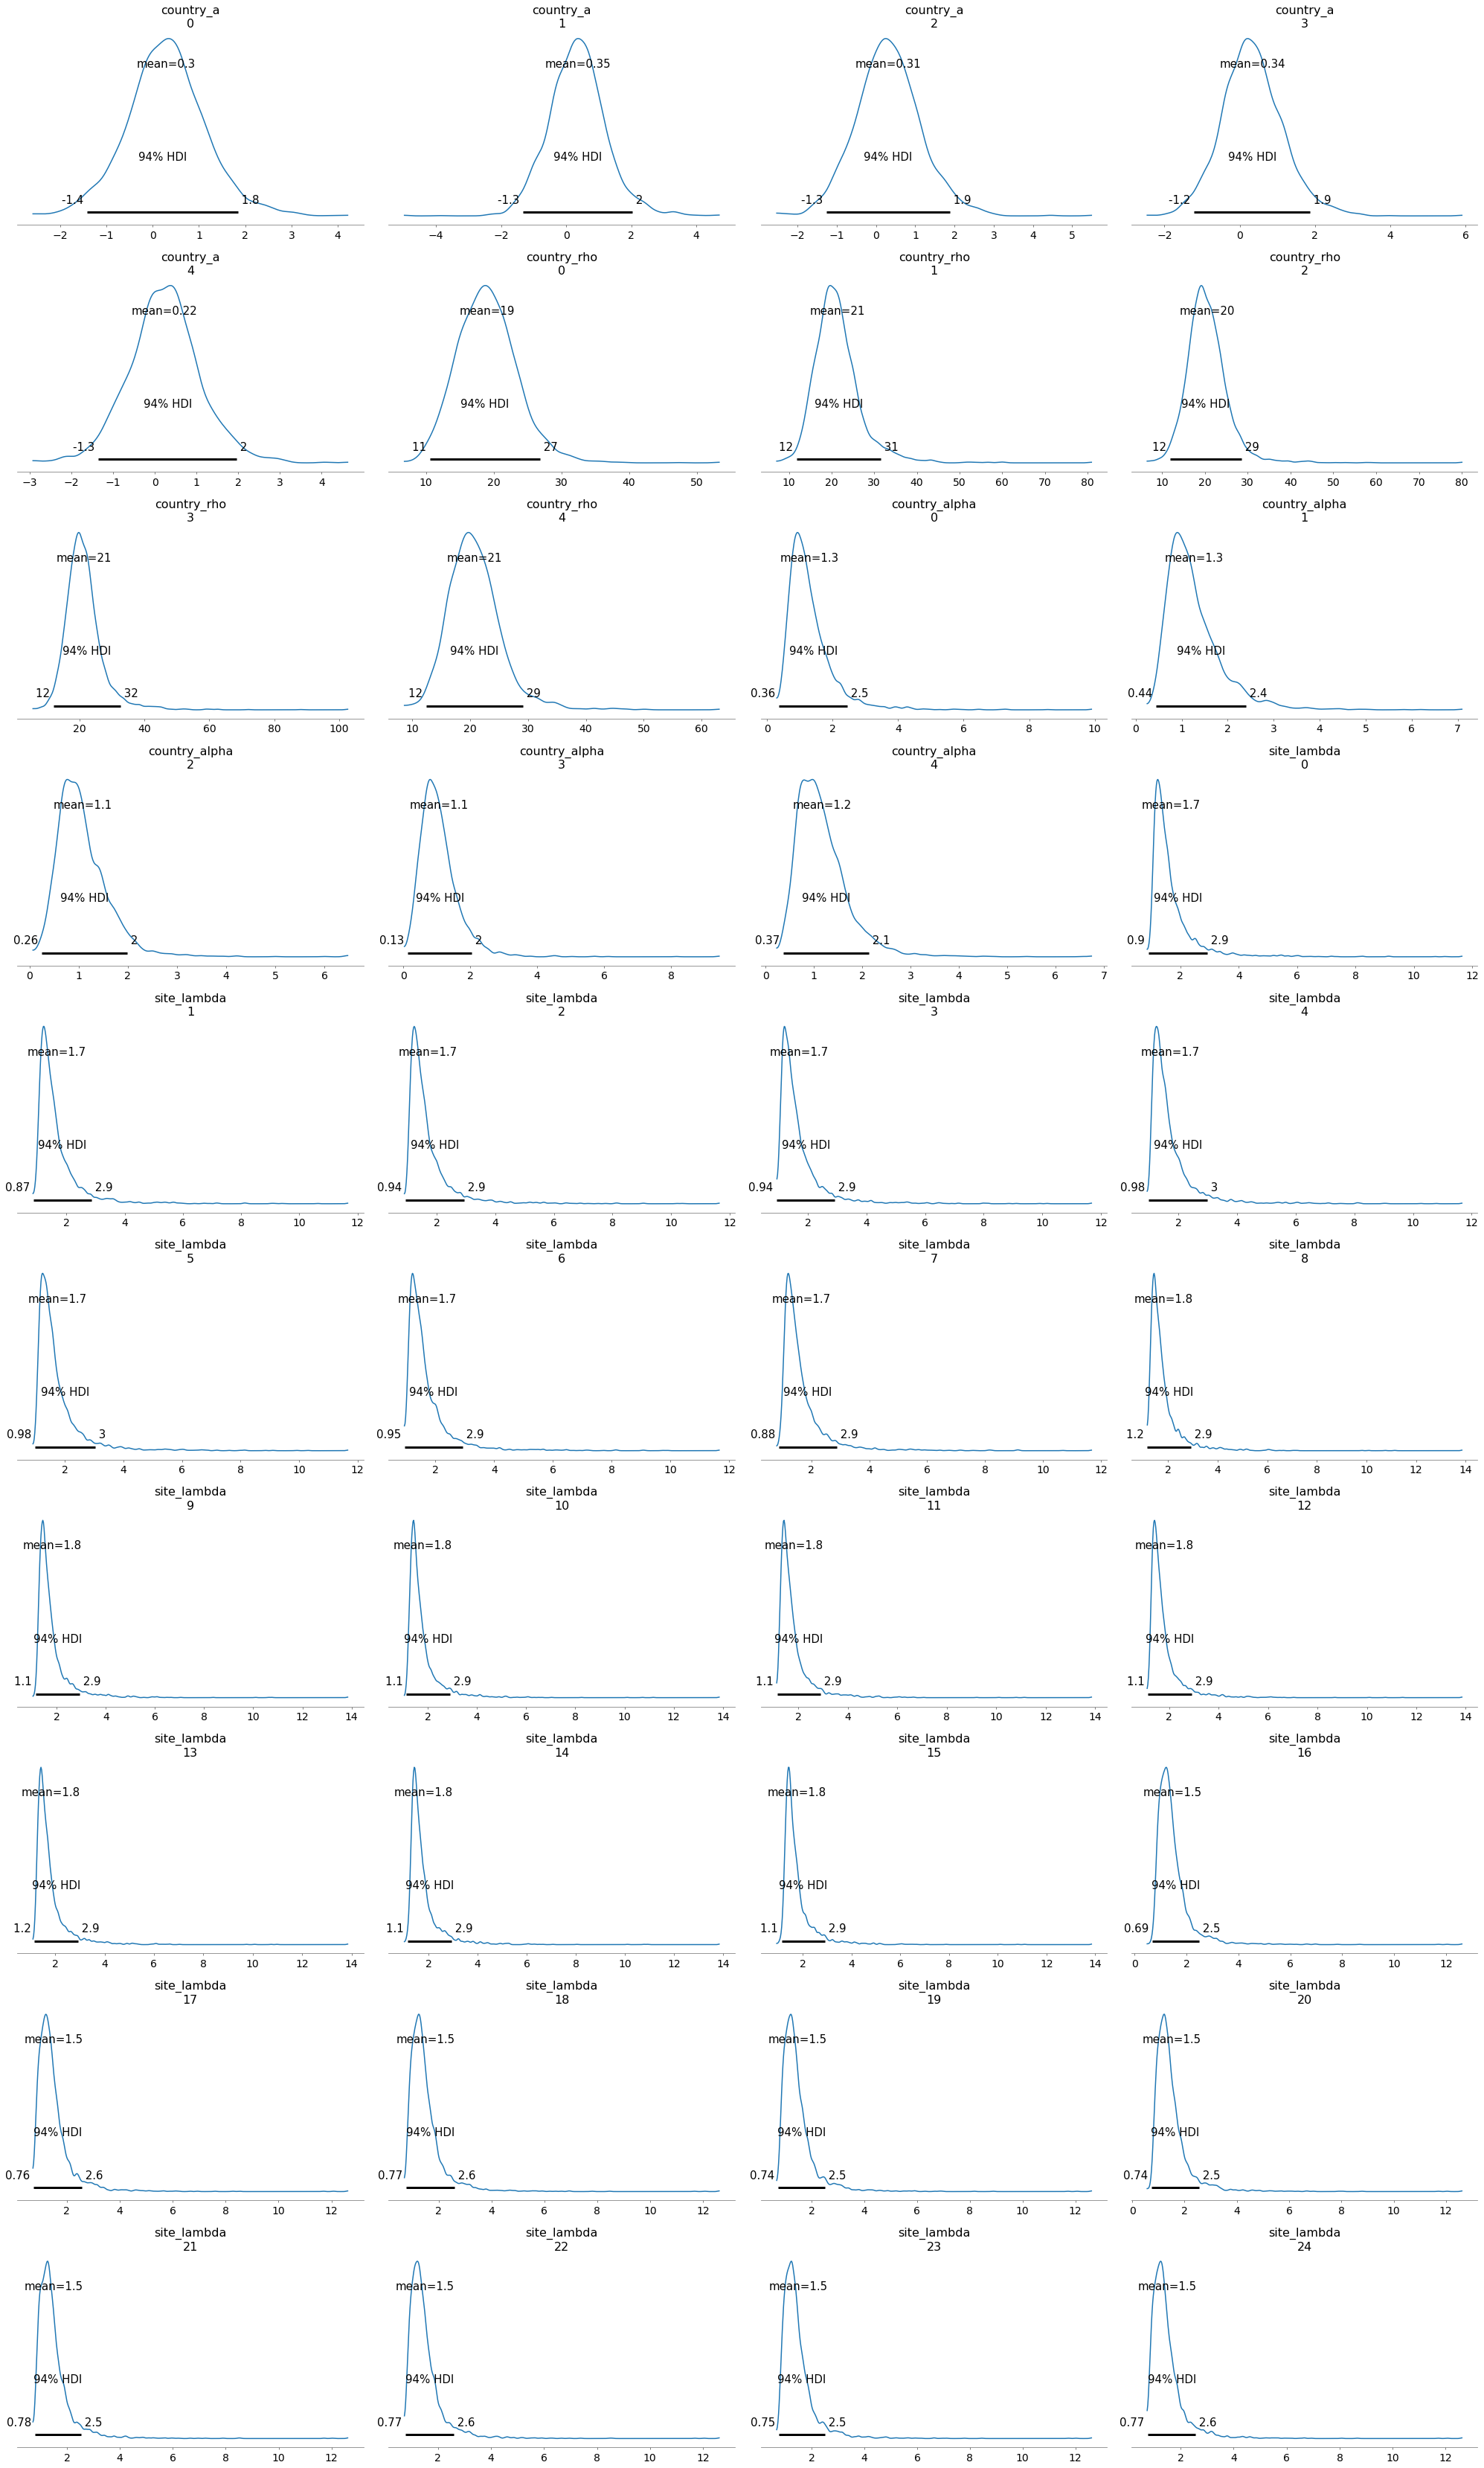

In [63]:
az.plot_posterior(hsgcpt_arviz, var_names=['country_a', 'country_rho', 'country_alpha', 'site_lambda'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff722c8b3d0>,
      dtype=object)

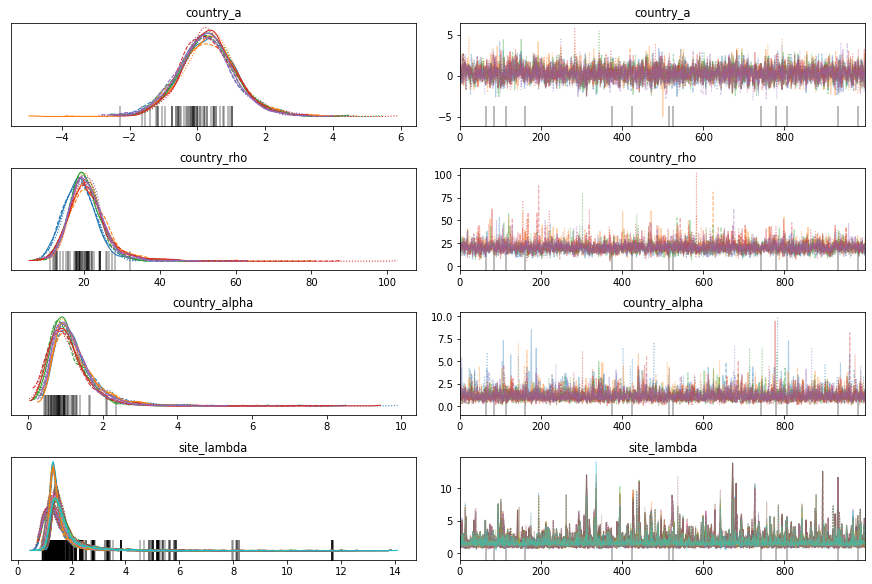

In [64]:
az.plot_trace(hsgcpt_arviz, var_names=['country_a', 'country_rho', 'country_alpha', 'site_lambda'])

# Posterior Plots

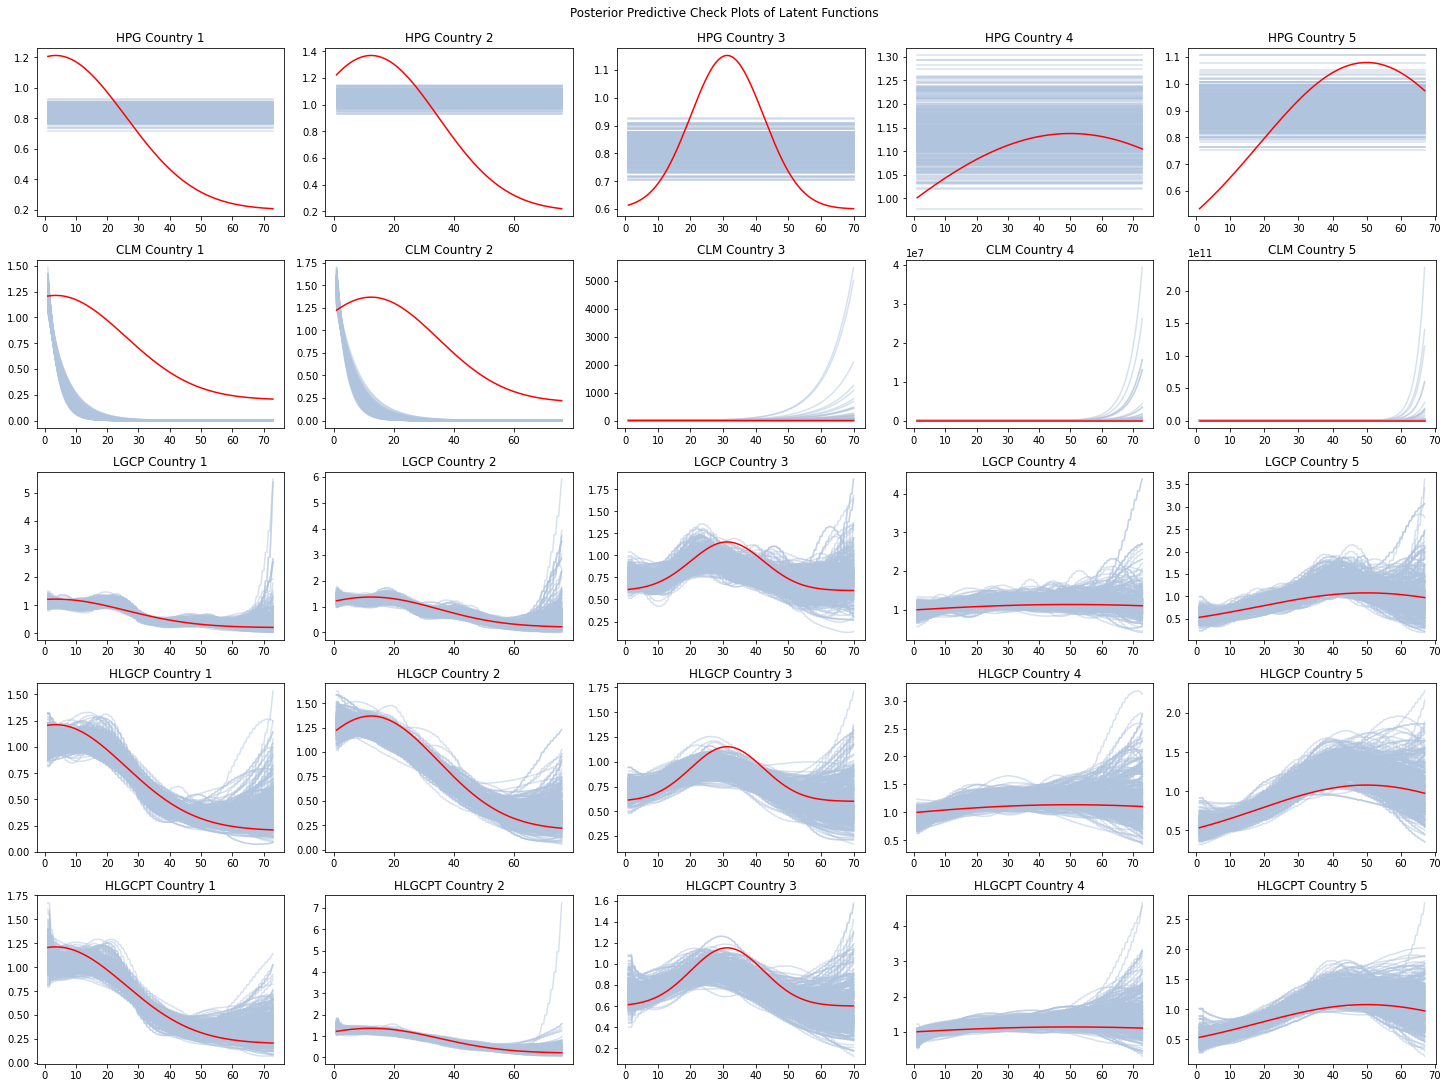

In [177]:
model_list = ['HPG','CLM','LGCP', 'HLGCP', 'HLGCPT'
#               ,'HSGCP','HSGCPT'
             ]

fig, axs = plt.subplots(5,5, figsize=(20,15),  constrained_layout=True)
fig.suptitle('Posterior Predictive Check Plots of Latent Functions')
for k in range(5):
    for j in range(5):
        for i in np.random.randint(0, 1000, 400):
            if k==0: 
                axs[k,j].plot(x_tilde[j], func_mat1[k,i,j,:], color='lightsteelblue',
                alpha = 0.5)
            elif k==1: 
                axs[k,j].plot(x_tilde[j], func_mat1[k,i,j,:], color='lightsteelblue',
                alpha = 0.5)
            else :
                axs[k,j].plot(x_tilde[j], func_mat2[k-2,i,j,:], color='lightsteelblue',
                alpha = 0.5)
        axs[k,j].plot(x_tilde[j], intensity[j], color='red')
        axs[k,j].set_title(str(model_list[k])+' Country ' + str(j+1))

## Model Comparison

In [36]:
compare_dict = {
    "HPG":hpg_arviz, 
    "HHPG":hhpg_arviz, 
    "CLM":clm_arviz, 
    "HCLM":hclm_arviz, 
    "LGCP":lgcp_arviz, 
    "HLGCP":hlgcp_arviz, 
    "HLGCPT":hlgcpt_arviz, 
    "HSGCP":hsgcp_arviz, 
    "HSGCPT":hsgcpt_arviz
}
df_comp_loo = az.compare(compare_dict)

/Users/skim/opt/anaconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/skim/opt/anaconda3/envs/stan/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/skim/opt/anaconda3/envs/stan/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/skim/opt/anaconda3/envs/stan/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/skim/opt/anaconda3/envs/stan/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=

In [37]:
pd.options.display.float_format = '{:.2f}'.format

In [38]:
df_comp_loo = df_comp_loo[['rank','loo','se','weight','loo_scale']]

In [192]:
print(df_comp_loo.to_latex(index=False))  

\begin{tabular}{rrrrl}
\toprule
 rank &      loo &    se &  weight & loo\_scale \\
\midrule
    0 & -3047.06 & 35.53 &    0.35 &       log \\
    1 & -3047.12 & 35.58 &    0.26 &       log \\
    2 & -3047.40 & 35.57 &    0.00 &       log \\
    3 & -3047.48 & 35.48 &    0.00 &       log \\
    4 & -3048.15 & 35.48 &    0.33 &       log \\
    5 & -3081.81 & 35.84 &    0.04 &       log \\
    6 & -3084.26 & 35.36 &    0.00 &       log \\
    7 & -3129.10 & 35.85 &    0.02 &       log \\
    8 & -3133.83 & 35.56 &    0.00 &       log \\
\bottomrule
\end{tabular}



# Posterior Summary Statistics

In [48]:
site_df = df.groupby(['site_number'])['week'].count()
site_df = pd.DataFrame([site_df]).T
site_df2 = site_df.reset_index(drop=True)

In [49]:
hpg_summary = az.summary(hpg_arviz, var_names = ['lambda'])[['mean','sd','hdi_3%','hdi_97%',
                                              'r_hat']]

In [50]:
hpg_summary.reset_index(level=0, inplace=True)
print(hpg_summary.to_latex(index=False)) 

\begin{tabular}{lrrrrr}
\toprule
    index &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
lambda[0] &  0.83 & 0.04 &    0.77 &     0.90 &   1.00 \\
lambda[1] &  1.05 & 0.04 &    0.98 &     1.13 &   1.00 \\
lambda[2] &  0.81 & 0.04 &    0.73 &     0.89 &   1.00 \\
lambda[3] &  1.14 & 0.06 &    1.04 &     1.25 &   1.00 \\
lambda[4] &  0.91 & 0.06 &    0.80 &     1.01 &   1.00 \\
\bottomrule
\end{tabular}



In [51]:
hhpg_summary = az.summary(hhpg_arviz, var_names = ['site_lambda'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [52]:
hhpg_summary.reset_index(level=0, inplace=True)
hhpg_summary = pd.concat([hhpg_summary, site_df2], axis=1)[['index','week','mean','sd','hdi_3%','hdi_97%','r_hat']]
print(hhpg_summary.to_latex(index=False))  

\begin{tabular}{lrrrrrr}
\toprule
          index &  week &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
 site\_lambda[0] &    44 &  0.85 & 0.06 &    0.76 &     0.98 &   1.09 \\
 site\_lambda[1] &    67 &  0.84 & 0.06 &    0.73 &     0.95 &   1.03 \\
 site\_lambda[2] &   124 &  0.82 & 0.05 &    0.74 &     0.91 &   1.02 \\
 site\_lambda[3] &    99 &  0.83 & 0.05 &    0.73 &     0.92 &   1.02 \\
 site\_lambda[4] &    90 &  0.85 & 0.05 &    0.76 &     0.96 &   1.06 \\
 site\_lambda[5] &    75 &  0.86 & 0.07 &    0.73 &     0.98 &   1.05 \\
 site\_lambda[6] &    71 &  0.86 & 0.06 &    0.77 &     0.98 &   1.02 \\
 site\_lambda[7] &   114 &  0.79 & 0.07 &    0.66 &     0.89 &   1.21 \\
 site\_lambda[8] &    86 &  1.24 & 0.11 &    1.05 &     1.45 &   1.04 \\
 site\_lambda[9] &    27 &  1.20 & 0.17 &    0.92 &     1.51 &   1.05 \\
site\_lambda[10] &   159 &  0.91 & 0.07 &    0.78 &     1.03 &   1.01 \\
site\_lambda[11] &    26 &  1.36 & 0.20 &    1.04 &     1.76 &   1.06 \\
site

In [53]:
clm_summary = az.summary(clm_arviz, var_names = ['country_a','country_b'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [54]:
clm_summary.reset_index(level=0, inplace=True)
print(clm_summary.to_latex(index=False)) 

\begin{tabular}{lrrrrr}
\toprule
       index &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
country\_a[0] &  0.47 & 0.10 &    0.30 &     0.65 &   1.00 \\
country\_a[1] &  0.60 & 0.09 &    0.43 &     0.77 &   1.00 \\
country\_a[2] & -0.20 & 0.13 &   -0.44 &     0.05 &   1.00 \\
country\_a[3] & -0.15 & 0.14 &   -0.40 &     0.12 &   1.00 \\
country\_a[4] & -0.75 & 0.19 &   -1.10 &    -0.37 &   1.00 \\
country\_b[0] & -0.25 & 0.04 &   -0.32 &    -0.19 &   1.00 \\
country\_b[1] & -0.21 & 0.03 &   -0.28 &    -0.15 &   1.00 \\
country\_b[2] &  0.00 & 0.04 &   -0.08 &     0.09 &   1.00 \\
country\_b[3] &  0.10 & 0.05 &    0.02 &     0.19 &   1.00 \\
country\_b[4] &  0.23 & 0.06 &    0.11 &     0.35 &   1.00 \\
\bottomrule
\end{tabular}



In [55]:
hclm_summary = az.summary(hclm_arviz, var_names = ['site_a','site_b'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [56]:
site_df22 = pd.concat([site_df2]*2, ignore_index=True)

In [57]:
hclm_summary.reset_index(level=0, inplace=True)
hclm_summary = pd.concat([hclm_summary, site_df22], axis=1)[['index','week','mean','sd','hdi_3%','hdi_97%','r_hat']]
print(hclm_summary.to_latex(index=False))  

\begin{tabular}{lrrrrrr}
\toprule
     index &  week &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
 site\_a[0] &    44 &  0.43 & 0.10 &    0.22 &     0.61 &   1.00 \\
 site\_a[1] &    67 &  0.43 & 0.10 &    0.24 &     0.63 &   1.00 \\
 site\_a[2] &   124 &  0.43 & 0.10 &    0.24 &     0.63 &   1.00 \\
 site\_a[3] &    99 &  0.43 & 0.11 &    0.23 &     0.62 &   1.00 \\
 site\_a[4] &    90 &  0.43 & 0.10 &    0.23 &     0.63 &   1.00 \\
 site\_a[5] &    75 &  0.44 & 0.11 &    0.23 &     0.63 &   1.00 \\
 site\_a[6] &    71 &  0.43 & 0.10 &    0.24 &     0.64 &   1.00 \\
 site\_a[7] &   114 &  0.42 & 0.11 &    0.22 &     0.61 &   1.00 \\
 site\_a[8] &    86 &  0.54 & 0.11 &    0.34 &     0.76 &   1.00 \\
 site\_a[9] &    27 &  0.52 & 0.11 &    0.32 &     0.72 &   1.00 \\
site\_a[10] &   159 &  0.53 & 0.11 &    0.32 &     0.73 &   1.00 \\
site\_a[11] &    26 &  0.54 & 0.11 &    0.34 &     0.74 &   1.00 \\
site\_a[12] &    75 &  0.52 & 0.11 &    0.32 &     0.72 &   1.00 \\
s

In [58]:
lgcp_summary = az.summary(lgcp_arviz, var_names = ['country_rho','country_alpha','country_a'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [59]:
lgcp_summary.reset_index(level=0, inplace=True)
print(lgcp_summary.to_latex(index=False)) 

\begin{tabular}{lrrrrr}
\toprule
           index &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
  country\_rho[0] & 10.81 & 1.59 &    7.74 &    13.71 &   1.00 \\
  country\_rho[1] & 10.83 & 1.79 &    7.62 &    14.26 &   1.00 \\
  country\_rho[2] & 10.22 & 1.95 &    6.80 &    14.04 &   1.00 \\
  country\_rho[3] & 10.29 & 2.00 &    6.24 &    13.84 &   1.00 \\
  country\_rho[4] & 11.04 & 1.87 &    7.45 &    14.41 &   1.00 \\
country\_alpha[0] &  0.70 & 0.28 &    0.26 &     1.18 &   1.00 \\
country\_alpha[1] &  0.68 & 0.27 &    0.26 &     1.16 &   1.00 \\
country\_alpha[2] &  0.27 & 0.18 &    0.01 &     0.57 &   1.00 \\
country\_alpha[3] &  0.19 & 0.16 &    0.00 &     0.46 &   1.00 \\
country\_alpha[4] &  0.45 & 0.20 &    0.15 &     0.83 &   1.00 \\
    country\_a[0] & -0.52 & 0.41 &   -1.39 &     0.19 &   1.01 \\
    country\_a[1] & -0.30 & 0.39 &   -1.03 &     0.45 &   1.00 \\
    country\_a[2] & -0.26 & 0.22 &   -0.65 &     0.11 &   1.00 \\
    country\_a[3] &  0.12 & 0.

In [65]:
hlgcp_summary = az.summary(hlgcp_arviz, var_names = ['country_rho','country_alpha','country_a'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [66]:
hlgcp_summary.reset_index(level=0, inplace=True)
print(hlgcp_summary.to_latex(index=False))  

\begin{tabular}{lrrrrr}
\toprule
           index &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
  country\_rho[0] & 20.94 & 4.53 &   11.95 &    29.16 &   1.00 \\
  country\_rho[1] & 23.26 & 5.14 &   14.17 &    33.55 &   1.00 \\
  country\_rho[2] & 21.88 & 4.68 &   13.14 &    30.29 &   1.00 \\
  country\_rho[3] & 23.47 & 6.13 &   13.64 &    34.38 &   1.00 \\
  country\_rho[4] & 22.35 & 4.85 &   13.77 &    30.99 &   1.00 \\
country\_alpha[0] &  0.54 & 0.18 &    0.28 &     0.85 &   1.01 \\
country\_alpha[1] &  0.54 & 0.18 &    0.26 &     0.85 &   1.01 \\
country\_alpha[2] &  0.45 & 0.16 &    0.15 &     0.73 &   1.01 \\
country\_alpha[3] &  0.45 & 0.16 &    0.16 &     0.73 &   1.00 \\
country\_alpha[4] &  0.49 & 0.16 &    0.24 &     0.80 &   1.00 \\
    country\_a[0] & -0.31 & 0.24 &   -0.79 &     0.11 &   1.01 \\
    country\_a[1] & -0.26 & 0.24 &   -0.72 &     0.18 &   1.00 \\
    country\_a[2] & -0.28 & 0.22 &   -0.69 &     0.15 &   1.00 \\
    country\_a[3] & -0.13 & 0.

In [67]:
hlgcpt_summary = az.summary(hlgcpt_arviz, var_names = ['country_rho','country_alpha','country_a','country_b'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [68]:
hlgcpt_summary.reset_index(level=0, inplace=True)
print(hlgcpt_summary.to_latex(index=False))  

\begin{tabular}{lrrrrr}
\toprule
           index &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
  country\_rho[0] & 20.15 & 4.19 &   12.14 &    27.64 &   1.00 \\
  country\_rho[1] & 22.27 & 5.13 &   13.68 &    31.83 &   1.00 \\
  country\_rho[2] & 21.27 & 4.60 &   13.15 &    29.84 &   1.00 \\
  country\_rho[3] & 22.55 & 6.04 &   13.72 &    32.95 &   1.00 \\
  country\_rho[4] & 21.71 & 4.89 &   12.85 &    30.32 &   1.00 \\
country\_alpha[0] &  0.52 & 0.19 &    0.26 &     0.88 &   1.00 \\
country\_alpha[1] &  0.51 & 0.18 &    0.24 &     0.84 &   1.00 \\
country\_alpha[2] &  0.42 & 0.17 &    0.13 &     0.74 &   1.00 \\
country\_alpha[3] &  0.38 & 0.17 &    0.06 &     0.67 &   1.00 \\
country\_alpha[4] &  0.46 & 0.17 &    0.19 &     0.77 &   1.00 \\
    country\_a[0] & -0.23 & 0.28 &   -0.79 &     0.26 &   1.00 \\
    country\_a[1] & -0.20 & 0.28 &   -0.72 &     0.35 &   1.00 \\
    country\_a[2] & -0.24 & 0.27 &   -0.77 &     0.25 &   1.00 \\
    country\_a[3] & -0.21 & 0.

In [69]:
hsgcp_country_summary = az.summary(hsgcp_arviz, var_names = ['country_rho','country_alpha','country_a'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [72]:
hsgcp_country_summary.reset_index(level=0, inplace=True)
print(hsgcp_country_summary.to_latex(index=False))  

\begin{tabular}{lrrrrr}
\toprule
           index &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
  country\_rho[0] & 20.54 & 4.69 &   11.59 &    28.76 &   1.00 \\
  country\_rho[1] & 22.38 & 5.72 &   13.24 &    33.31 &   1.00 \\
  country\_rho[2] & 21.50 & 5.08 &   12.27 &    30.20 &   1.00 \\
  country\_rho[3] & 22.24 & 5.59 &   12.35 &    31.89 &   1.00 \\
  country\_rho[4] & 21.98 & 5.20 &   12.41 &    30.96 &   1.00 \\
country\_alpha[0] &  1.28 & 0.67 &    0.43 &     2.32 &   1.00 \\
country\_alpha[1] &  1.25 & 0.57 &    0.46 &     2.24 &   1.00 \\
country\_alpha[2] &  1.05 & 0.50 &    0.26 &     1.96 &   1.00 \\
country\_alpha[3] &  1.16 & 0.70 &    0.22 &     2.33 &   1.00 \\
country\_alpha[4] &  1.14 & 0.50 &    0.39 &     2.07 &   1.00 \\
    country\_a[0] & -0.09 & 0.81 &   -1.69 &     1.39 &   1.00 \\
    country\_a[1] & -0.03 & 0.80 &   -1.56 &     1.45 &   1.00 \\
    country\_a[2] & -0.01 & 0.84 &   -1.62 &     1.46 &   1.00 \\
    country\_a[3] &  0.22 & 0.

In [73]:
hsgcp_site_summary = az.summary(hsgcp_arviz, var_names = ['site_lambda'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [74]:
hsgcp_site_summary.reset_index(level=0, inplace=True)
hsgcp_site_summary = pd.concat([hsgcp_site_summary, site_df2], axis=1)[['index','week','mean','sd','hdi_3%','hdi_97%','r_hat']]
print(hsgcp_site_summary.to_latex(index=False))  

\begin{tabular}{lrrrrrr}
\toprule
          index &  week &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
 site\_lambda[0] &    44 &  1.78 & 0.96 &    0.91 &     3.30 &   1.00 \\
 site\_lambda[1] &    67 &  1.77 & 0.95 &    0.89 &     3.30 &   1.00 \\
 site\_lambda[2] &   124 &  1.80 & 0.98 &    0.94 &     3.29 &   1.00 \\
 site\_lambda[3] &    99 &  1.81 & 0.97 &    0.93 &     3.37 &   1.00 \\
 site\_lambda[4] &    90 &  1.83 & 1.01 &    0.95 &     3.39 &   1.00 \\
 site\_lambda[5] &    75 &  1.85 & 1.03 &    0.95 &     3.47 &   1.00 \\
 site\_lambda[6] &    71 &  1.81 & 0.99 &    0.92 &     3.37 &   1.00 \\
 site\_lambda[7] &   114 &  1.76 & 0.94 &    0.90 &     3.25 &   1.00 \\
 site\_lambda[8] &    86 &  1.96 & 1.00 &    1.14 &     3.54 &   1.00 \\
 site\_lambda[9] &    27 &  1.94 & 0.98 &    1.13 &     3.48 &   1.00 \\
site\_lambda[10] &   159 &  1.91 & 0.97 &    1.11 &     3.48 &   1.00 \\
site\_lambda[11] &    26 &  1.96 & 0.99 &    1.14 &     3.53 &   1.00 \\
site

In [75]:
hsgcpt_country_summary = az.summary(hsgcpt_arviz, var_names = ['country_rho','country_alpha','country_a','country_b'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [76]:
hsgcpt_country_summary.reset_index(level=0, inplace=True)
print(hsgcpt_country_summary.to_latex(index=False))  

\begin{tabular}{lrrrrr}
\toprule
           index &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
  country\_rho[0] & 19.06 & 4.44 &   10.54 &    26.81 &   1.00 \\
  country\_rho[1] & 21.42 & 5.65 &   11.86 &    31.48 &   1.00 \\
  country\_rho[2] & 20.49 & 4.92 &   11.91 &    28.56 &   1.00 \\
  country\_rho[3] & 21.27 & 6.17 &   11.95 &    32.47 &   1.00 \\
  country\_rho[4] & 20.78 & 4.77 &   12.41 &    29.06 &   1.00 \\
country\_alpha[0] &  1.30 & 0.73 &    0.36 &     2.45 &   1.00 \\
country\_alpha[1] &  1.26 & 0.62 &    0.44 &     2.39 &   1.00 \\
country\_alpha[2] &  1.08 & 0.54 &    0.26 &     1.99 &   1.00 \\
country\_alpha[3] &  1.07 & 0.61 &    0.13 &     2.04 &   1.00 \\
country\_alpha[4] &  1.17 & 0.56 &    0.37 &     2.14 &   1.00 \\
    country\_a[0] &  0.30 & 0.85 &   -1.42 &     1.85 &   1.00 \\
    country\_a[1] &  0.35 & 0.89 &   -1.33 &     2.03 &   1.00 \\
    country\_a[2] &  0.31 & 0.83 &   -1.27 &     1.88 &   1.00 \\
    country\_a[3] &  0.34 & 0.

In [77]:
hsgcpt_site_summary = az.summary(hsgcpt_arviz, var_names = ['site_lambda'])[
    ['mean','sd','hdi_3%','hdi_97%','r_hat']]

In [78]:
hsgcpt_site_summary.reset_index(level=0, inplace=True)
hsgcpt_site_summary = pd.concat([hsgcpt_site_summary, site_df2], axis=1)[['index','week','mean','sd','hdi_3%','hdi_97%','r_hat']]

In [79]:
# hsgcpt_site_summary['index'] = hsgcpt_site_summary['index'].shift(-1)
print(hsgcpt_site_summary.to_latex(index=False))  

\begin{tabular}{lrrrrrr}
\toprule
          index &  week &  mean &   sd &  hdi\_3\% &  hdi\_97\% &  r\_hat \\
\midrule
 site\_lambda[0] &    44 &  1.68 & 0.85 &    0.91 &     2.91 &   1.00 \\
 site\_lambda[1] &    67 &  1.67 & 0.84 &    0.87 &     2.85 &   1.00 \\
 site\_lambda[2] &   124 &  1.69 & 0.85 &    0.94 &     2.93 &   1.00 \\
 site\_lambda[3] &    99 &  1.70 & 0.85 &    0.94 &     2.92 &   1.00 \\
 site\_lambda[4] &    90 &  1.72 & 0.87 &    0.97 &     2.98 &   1.00 \\
 site\_lambda[5] &    75 &  1.73 & 0.87 &    0.97 &     3.03 &   1.00 \\
 site\_lambda[6] &    71 &  1.70 & 0.86 &    0.95 &     2.93 &   1.00 \\
 site\_lambda[7] &   114 &  1.66 & 0.84 &    0.88 &     2.88 &   1.00 \\
 site\_lambda[8] &    86 &  1.82 & 0.77 &    1.15 &     2.92 &   1.00 \\
 site\_lambda[9] &    27 &  1.80 & 0.76 &    1.14 &     2.92 &   1.00 \\
site\_lambda[10] &   159 &  1.78 & 0.75 &    1.14 &     2.90 &   1.00 \\
site\_lambda[11] &    26 &  1.82 & 0.77 &    1.15 &     2.92 &   1.00 \\
site